In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)
import cloudscraper
from bs4 import BeautifulSoup
import scrapy
import time

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [ ]:
# This function is used for visualization of cost/area in a specified district
def plot_scatter_chart(df,district):
    bed2 = df1[(df1.district==district) & (df1.bed==2)]
    bed3 = df1[(df1.district==district) & (df1.bed==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bed2.area,bed2.price,color='black',label='2 bed', s=50)
    plt.scatter(bed3.area,bed3.price,marker='+', color='green',label='3 bed', s=50)
    plt.xlabel("Total Square Meter Area")
    plt.ylabel("Price (Bln VND)")
    plt.title(district)
    plt.legend()

In [ ]:
# This function is used for visualization and comparision of 2 specified district
def plot_scatter_chart_compare(df, district1, district2):
    bed2dis1 = df1[(df1.district==district1) & (df1.bed==2)]
    bed3dis1 = df1[(df1.district==district1) & (df1.bed>=3)]
    
    bed2dis2 = df1[(df1.district==district2) & (df1.bed==2)]
    bed3dis2 = df1[(df1.district==district2) & (df1.bed>=3)]
    
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bed2dis1.area,bed2dis1.price,color='black',label='2 bed d1', s=10)
    plt.scatter(bed3dis1.area,bed3dis1.price,marker='+', color='green',label='3 bed d1', s=10)
    
    plt.scatter(bed2dis2.area,bed2dis2.price,color='yellow',label='2 bed d2', s=10)
    plt.scatter(bed3dis2.area,bed3dis2.price,marker='v', color='orange',label='3 bed d2', s=10)
    
    plt.xlabel("Total Square Meter Area")
    plt.ylabel("Price (Bln VND)")
    plt.title(district1)
    plt.legend()

## Hi guys, welcome to our presentation!!

Our house prediction model is built with housing data in Ho Chi Minh City, Vietnam. The prediction price range is between 3 and 5 billion VND. We chose this location because Rachel and Dat both live in different cities, so we've picked the city in the middle. :>>>


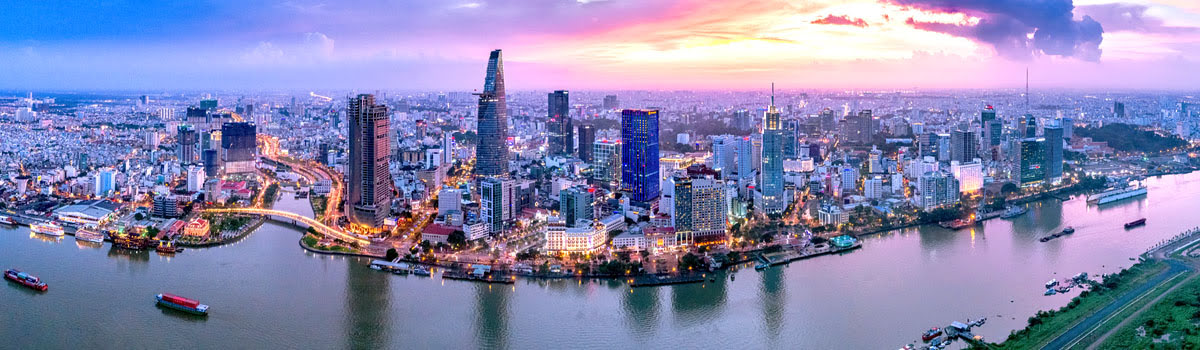


## In the model, we will go through 4 main steps:
1. PREPROCESSING DATA
2. DATA EXPLORATION
3. COMPARING MODELS
4. BUILDING MODELS

# CRAWL DATA FROM THE WEB

In [ ]:

def get_soup(url):

    scraper = cloudscraper.create_scraper()
    res = scraper.get(url).content
    soup = BeautifulSoup(res, 'html.parser')
    
    return soup


def scrape_product(soup):
    products = soup.find_all('a', {'class': 'js__product-link-for-product-id'})
    links = ['https://batdongsan.com.vn/' + product['href'] for product in products if 'href' in product.attrs]
    return links

def scrape_titles(soup):
    products = soup.find_all('span', {'class': 'pr-title js__card-title'})
    return products

We crawl data that is available in most of records, so that we can minimize null values. We crawl around 5000 records.
After crawling, we export the dataset in csv file for other steps.

In [ ]:

url = "https://batdongsan.com.vn/ban-can-ho-chung-cu-tp-hcm/gia-tu-3-ty-den-5-ty?cIds=362%2C41%2C325%2C163%2C575%2C44%2C562&fbclid=IwAR3sP0rem-wCJCeo6dKhqdyhGHUEs3HYHKAD0R1njR4BJKD1v7jDHXECdGI"
soup = get_soup(url)

# Find the number of page
last_page = soup.find_all('a', {'class': 're__pagination-number'})
num_page = int(last_page[-1].text.strip())
num_page

# Create the list containing the links
product_list = []

# Loop through all the links and append to the list
for i in range(1, num_page + 1):
    k = 0
    while k < 3:
        try:
            j = 0
            while j < 10:
                try:
                    url = 'https://batdongsan.com.vn/ban-can-ho-chung-cu-tp-hcm/gia-tu-3-ty-den-5-ty?cIds=362%2C41%2C325%2C163%2C575%2C44%2C562&fbclid=IwAR3sP0rem-wCJCeo6dKhqdyhGHUEs3HYHKAD0R1njR4BJKD1v7jDHXECdGI' if i == 1 else f'https://batdongsan.com.vn/ban-can-ho-chung-cu-tp-hcm/gia-tu-3-ty-den-5-ty/p{i}?cIds=362,41,325,163,575,44,562'

                    soup = get_soup(url)
                    products = scrape_product(soup)
                    if len(products) != 0:
                        break
                except Exception:
                    j += 1
                    time.sleep(5)
                
            titles = scrape_titles(soup)
            titles = [title.text.strip() for title in titles]

            for product in products:
                f = 0
                while f < 5:
                    try:
                        url = product
                        soup = get_soup(url)

                        title_spans = soup.find_all('span', {'class': 're__pr-specs-content-item-title'})
                        address = soup.find('span', {'class': 're__pr-short-description js__pr-address'})
                        address = address.text.strip() if address else None
                        address_components = address.split(', ') if address else None
                        
                        city = address_components[-1] if address else None
                        district = address_components[-2] if address else None
                        ward_commune = address_components[-3] if address else None
                        street = address_components[-4] if address else None
                        
                        title = titles[0]
                        titles.pop(0)
                        
                        for title_span in title_spans:
                            if title_span.text.strip() == 'Diện tích':
                                area_span = title_span.find_next_sibling('span', {'class': 're__pr-specs-content-item-value'})
                                area = area_span.text.strip() if area_span else None
                            elif title_span.text.strip() == 'Mức giá':
                                price_span = title_span.find_next_sibling('span', {'class': 're__pr-specs-content-item-value'})
                                price = price_span.text.strip().split()[0] if price_span else None
                            elif title_span.text.strip() == 'Số phòng ngủ':
                                bed_span = title_span.find_next_sibling('span', {'class': 're__pr-specs-content-item-value'})
                                bed = bed_span.text.strip().split()[0] if bed_span else None
                            elif title_span.text.strip() == 'Số toilet':
                                toilet_span = title_span.find_next_sibling('span', {'class': 're__pr-specs-content-item-value'})
                                toilet = toilet_span.text.strip().split()[0] if toilet_span else None
                            elif title_span.text.strip() == 'Pháp lý':
                                legal_status_span = title_span.find_next_sibling('span', {'class': 're__pr-specs-content-item-value'})
                                legal_status = legal_status_span.text.strip() if legal_status_span else None
                            elif title_span.text.strip() == 'Nội thất':
                                furniture_span = title_span.find_next_sibling('span', {'class': 're__pr-specs-content-item-value'})
                                furniture = furniture_span.text.strip() if furniture_span else None
                        
                        product = {
                            'url': url,
                            'title': title,
                            'city': city,
                            'district': district if address else None,
                            'ward_commune': ward_commune if address else None,
                            'street': street if address else None,
                            'area': area,
                            'bed': bed,
                            'toilet': toilet,
                            'legal_status': legal_status,
                            'furniture': furniture,
                            'price': price
                        }
                        print(product)
                        product_list.append(product)
                        break
                    except Exception as e:
                        f += 1
                        print(e)
                        time.sleep(5)
            # Convert to DataFrame and save to CSV
            df = pd.DataFrame(product_list)
            df.to_csv('scraped_data.csv', index=False, encoding='utf-8-sig')
            print(f"Page {i} scraped and saved.")
            break  
        except Exception as e:
            print(e)
            k += 1
            time.sleep(5)
            

## CLEAN DATA

First, we need to load the Data

In [19]:
df = pd.read_csv('scraped_data (1).csv')
df

,url,title,city,district,ward_commune,street,area,bed,toilet,legal_status,furniture,price
0,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng Privia Khang Điền giá tốt view đẹp cọ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,3
1,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Giỏ hàng Privia nhiều căn đẹp, chiết khấu 10% ...",Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,1"
2,https://batdongsan.com.vn//ban-can-ho-chung-cu...,ĐỘC QUYỀN RỔ HÀNG CELADON CITY MUA TRỰC TIẾP C...,Hồ Chí Minh,Tân Phú,Phường Sơn Kỳ,Đường N1,"85,4 m²",2,2,Sổ đỏ/ Sổ hồng,Đầy đủ,"4,35"
3,https://batdongsan.com.vn//ban-nha-rieng-duong...,"Bán nhà đường Mã Lò - Lê Văn Quới (4,5m x 12m)...",NaN,NaN,NaN,NaN,54 m²,4,5,Sổ đỏ/ Sổ hồng,Đầy đủ,"4,9"
4,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng nội bộ Akari City giá chỉ từ 700 triệ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường Võ Văn Kiệt,78 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,5"
...,...,...,...,...,...,...,...,...,...,...,...,...
5156,https://batdongsan.com.vn//ban-nha-rieng-duong...,Gần QL 13 - oto 7 chỗ đậu cửa - nhà mới vào ở ...,NaN,NaN,NaN,NaN,40 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"4,95"
5157,https://batdongsan.com.vn//ban-nha-rieng-duong...,"Nhỉnh 3 tỷ, khu vip Phan XÍch Long, P7, Phú Nh...",Hồ Chí Minh,Phú Nhuận,Phường 7,Đường Nhiêu Tứ,28 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,65"
5158,https://batdongsan.com.vn//ban-nha-rieng-duong...,60m2 - BTCT - nhà mới ở liền - ngang khủng 4.8...,Hồ Chí Minh,Bình Thạnh,Phường 12,Đường Nơ Trang Long,60 m²,3,2,Sổ đỏ/ Sổ hồng,Cơ bản,"4,8"
5159,https://batdongsan.com.vn//ban-nha-rieng-duong...,Nhà bán hẻm 1/ Phan Đình Phùng 35m2 P2 Phú Nhu...,Hồ Chí Minh,Phú Nhuận,Phường 2,Đường Phan Đình Phùng,35 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,6"


Test if the properties are really in the targeted city (sometimes some sponsored properties outside of HCMC could be mistakenly crawled)

In [20]:
print(df['city'].value_counts())

city
Hồ Chí Minh     2702
Hồ Chí Minh.      62
Name: count, dtype: int64


Oops, it seems that all data is in HCM but HCM city is written into 2 other ways so pandas split it into 2 catergories. So we will combine it into 1.

In [21]:
df['city'] = df['city'].str.replace('Hồ Chí Minh\.', 'Hồ Chí Minh', regex=True)

print(df['city'].value_counts())

city
Hồ Chí Minh    2764
Name: count, dtype: int64


In [14]:
df.head(5)

,url,title,city,district,ward_commune,street,area,bed,toilet,legal_status,furniture,price
0,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng Privia Khang Điền giá tốt view đẹp cọ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,3
1,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Giỏ hàng Privia nhiều căn đẹp, chiết khấu 10% ...",Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,1"
2,https://batdongsan.com.vn//ban-can-ho-chung-cu...,ĐỘC QUYỀN RỔ HÀNG CELADON CITY MUA TRỰC TIẾP C...,Hồ Chí Minh,Tân Phú,Phường Sơn Kỳ,Đường N1,"85,4 m²",2,2,Sổ đỏ/ Sổ hồng,Đầy đủ,"4,35"
3,https://batdongsan.com.vn//ban-nha-rieng-duong...,"Bán nhà đường Mã Lò - Lê Văn Quới (4,5m x 12m)...",NaN,NaN,NaN,NaN,54 m²,4,5,Sổ đỏ/ Sổ hồng,Đầy đủ,"4,9"
4,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng nội bộ Akari City giá chỉ từ 700 triệ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường Võ Văn Kiệt,78 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,5"


Drop rows with missing values

In [22]:
df = df.dropna()
df

,url,title,city,district,ward_commune,street,area,bed,toilet,legal_status,furniture,price
0,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng Privia Khang Điền giá tốt view đẹp cọ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,3
1,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Giỏ hàng Privia nhiều căn đẹp, chiết khấu 10% ...",Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,1"
2,https://batdongsan.com.vn//ban-can-ho-chung-cu...,ĐỘC QUYỀN RỔ HÀNG CELADON CITY MUA TRỰC TIẾP C...,Hồ Chí Minh,Tân Phú,Phường Sơn Kỳ,Đường N1,"85,4 m²",2,2,Sổ đỏ/ Sổ hồng,Đầy đủ,"4,35"
4,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng nội bộ Akari City giá chỉ từ 700 triệ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường Võ Văn Kiệt,78 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,5"
6,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Mở bán căn hộ Mizuki Park, Nguyễn Văn Linh, Bì...",Hồ Chí Minh,Bình Chánh,Xã Bình Hưng,Đường Nguyễn Văn Linh,82 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,4"
...,...,...,...,...,...,...,...,...,...,...,...,...
5154,https://batdongsan.com.vn//ban-nha-rieng-duong...,Bán nhà đường số 14 - khu Lê Văn Quới - giáp 4 Xã,Hồ Chí Minh,Bình Tân,Phường Bình Hưng Hòa A,Đường Số 14,32 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,55"
5155,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Cần bán Richmond City căn 38m2 từ 1tỷ61, 52m2 ...",Hồ Chí Minh,Bình Thạnh,Phường 26,Phố Nguyễn Xí,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,2"
5157,https://batdongsan.com.vn//ban-nha-rieng-duong...,"Nhỉnh 3 tỷ, khu vip Phan XÍch Long, P7, Phú Nh...",Hồ Chí Minh,Phú Nhuận,Phường 7,Đường Nhiêu Tứ,28 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,65"
5158,https://batdongsan.com.vn//ban-nha-rieng-duong...,60m2 - BTCT - nhà mới ở liền - ngang khủng 4.8...,Hồ Chí Minh,Bình Thạnh,Phường 12,Đường Nơ Trang Long,60 m²,3,2,Sổ đỏ/ Sổ hồng,Cơ bản,"4,8"


Reset index

In [23]:
df.reset_index(drop=True, inplace=True)
df

,url,title,city,district,ward_commune,street,area,bed,toilet,legal_status,furniture,price
0,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng Privia Khang Điền giá tốt view đẹp cọ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,3
1,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Giỏ hàng Privia nhiều căn đẹp, chiết khấu 10% ...",Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường An Dương Vương,66 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,1"
2,https://batdongsan.com.vn//ban-can-ho-chung-cu...,ĐỘC QUYỀN RỔ HÀNG CELADON CITY MUA TRỰC TIẾP C...,Hồ Chí Minh,Tân Phú,Phường Sơn Kỳ,Đường N1,"85,4 m²",2,2,Sổ đỏ/ Sổ hồng,Đầy đủ,"4,35"
3,https://batdongsan.com.vn//ban-can-ho-chung-cu...,Giỏ hàng nội bộ Akari City giá chỉ từ 700 triệ...,Hồ Chí Minh,Bình Tân,Phường An Lạc,Đường Võ Văn Kiệt,78 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,5"
4,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Mở bán căn hộ Mizuki Park, Nguyễn Văn Linh, Bì...",Hồ Chí Minh,Bình Chánh,Xã Bình Hưng,Đường Nguyễn Văn Linh,82 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,4"
...,...,...,...,...,...,...,...,...,...,...,...,...
2759,https://batdongsan.com.vn//ban-nha-rieng-duong...,Bán nhà đường số 14 - khu Lê Văn Quới - giáp 4 Xã,Hồ Chí Minh,Bình Tân,Phường Bình Hưng Hòa A,Đường Số 14,32 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,55"
2760,https://batdongsan.com.vn//ban-can-ho-chung-cu...,"Cần bán Richmond City căn 38m2 từ 1tỷ61, 52m2 ...",Hồ Chí Minh,Bình Thạnh,Phường 26,Phố Nguyễn Xí,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,2"
2761,https://batdongsan.com.vn//ban-nha-rieng-duong...,"Nhỉnh 3 tỷ, khu vip Phan XÍch Long, P7, Phú Nh...",Hồ Chí Minh,Phú Nhuận,Phường 7,Đường Nhiêu Tứ,28 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,65"
2762,https://batdongsan.com.vn//ban-nha-rieng-duong...,60m2 - BTCT - nhà mới ở liền - ngang khủng 4.8...,Hồ Chí Minh,Bình Thạnh,Phường 12,Đường Nơ Trang Long,60 m²,3,2,Sổ đỏ/ Sổ hồng,Cơ bản,"4,8"


Drop 'ward_commune' and 'street' because there could have same ward_commune and street name in other district.


For example, there could be more than 1 Vo Thi Sau street, on one of which the property is high-priced but not on the other. But it would mistakenly assign a high correlation to that street when it encounter again.


Drop 'url' and 'title' because it is just for attracting purchasers.


Drop 'city' because we just predict house in HCM.¶

In [24]:
df = df.drop(['ward_commune', 'street', 'url', 'title', 'city'], axis=1)
df

,district,area,bed,toilet,legal_status,furniture,price
0,Bình Tân,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,3
1,Bình Tân,66 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,1"
2,Tân Phú,"85,4 m²",2,2,Sổ đỏ/ Sổ hồng,Đầy đủ,"4,35"
3,Bình Tân,78 m²,2,2,Hợp đồng mua bán,Cơ bản,"3,5"
4,Bình Chánh,82 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,4"
...,...,...,...,...,...,...,...
2759,Bình Tân,32 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,55"
2760,Bình Thạnh,66 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,2"
2761,Phú Nhuận,28 m²,2,2,Sổ đỏ/ Sổ hồng,Cơ bản,"3,65"
2762,Bình Thạnh,60 m²,3,2,Sổ đỏ/ Sổ hồng,Cơ bản,"4,8"


In Furniture column, there are many values with same meaning but sellers express in different way so we catergorize it so that model will not be confused. Same with legal status

In [22]:
df.groupby('furniture')['furniture'].agg("count")

furniture
* Bàn giao hoàn thiện cơ bản. * Tặng tủ bếp trên, tủ bếp dưới. * Tặng full thiết bị vệ sinh cao cấp.                                                                                               4
+ Full hệ thống bếp: Tủ bếp trên, bếp dưới, bếp điện từ, máy hút mùi, đều thương hiệu Hafele bồn rửa Hafele, mặt đá Solit Soface, kính cường lực. Full thiết bị phòng WC: Tủ Lavabo trên, dưới.    2
- Nền được lát đá Marble cao cấp độc quyền nhập khẩu từ Italia. - Kính LowE 3 lớp - chống cháy, chống ẩm, tia UV, nhiệt độ. - 04 máy lạnh trung tâm âm trần LG. - Đầy đủ các thiết bị bếp...       3
- Tặng nội thất cao cấp: Sàn gỗ, khóa thẻ từ, tủ bếp gỗ, bếp ga Teka, thiết bị VS.                                                                                                                 1
Bang giao tiêu chuẩn cao cấp                                                                                                                                                                       2
     

In [25]:
# Define the mappings for furniture replacement
furniture_mappings = {
    # Basic
    'Tặng nội thất dính tường.': 'Basic',
    'Có nội thất cơ bản: 4 máy lạnh, bếp, máy hút mùi, rèm, tủ bếp trên dưới, đầy đủ thiết bị vệ sinh cao cấp, nhà mới chưa ở, giao nhà ngay...': 'Basic',
    'Có 3 máy lạnh.': 'Basic',
    'Thiết kế hiện đại, thoáng mát - Khách hàng có thể thiết kế nội thất theo ý mình.': 'Basic',
    'Hoàn thiện cơ bản.': 'Basic',
    'Máy lạnh': 'Basic',
    'Đã hoàn thiện cơ bản, thiết bị thương hiệu: Hafele, Duravit,đã hoàn thiện bếp, video call màn hình màu,...': 'Basic',
    'CƠ BẢN': 'Basic',
    'Cơn bản': 'Basic',
    'Bàn giao NT cơ bản.': 'Basic',
    'Máy lạnh, tủ bếp': 'Basic',
    'Tặng nội thất, căn góc.': 'Basic',
    'Mới, hiện đại': 'Basic',
    'Hoàn thiện bên ngoài và thô bên trong.': 'Basic',
    'Nội thất cơ bản CĐT.': 'Basic',
    'Nội thất cơ bản: Máy lạnh, bếp, máy nước nóng, tủ đồ âm tường.': 'Basic',
    'Hoàn thiện nội thất cơ bản, Sàn gỗ, bếp hồng ngoại, máy hút khói, bồn rửa chén, thiết bị vệ sinh đầy đủ': 'Basic',
    'Cầu thang kính cường lực, bếp cao cấp, cửa nhôm xingfa': 'Basic',
    'Nội thất bàn giao cao cấp.': 'Basic',
    'Bàn giao nhà hoàn thiện cơ bản cùng nội thất cao cấp chuẩn Châu Âu.': 'Basic',
    'Nhà nội thất cơ bản: Máy lạnh, bếp, máy nước nóng, tủ đồ âm tường...': 'Basic',
    'Tặng nội thất.': 'Basic',
    'Bàn giao nhà hoàn thiện cơ bản, full bếp, full WC.': 'Basic',
    'Nội thất hoàn thiện.': 'Basic',
    'Dính tường': 'Basic',
    'Nội thất được thiết kế lại rất đẹp.': 'Basic',
    'Tặng toàn bộ nội thất.': 'Basic',
    'Tặng nội thất. Nhà đẹp': 'Basic',
    'Nhà nội thất cơ bản, có máy lạnh âm trần và toilet giác vàng.': 'Basic',
    'Máy lạnh âm trần, tủ bếp, tủ quần áo, sàn gỗ, kính full trần.': 'Basic',
    'Cơ bản ở ngay': 'Basic',
    'Có nội thất cơ bản: Có máy lạnh, bếp...': 'Basic',
    'Đẹp': 'Basic',
    'Đã có nội thất.': 'Basic',
    'Nội thất cơ bản hoặc full nội thất': 'Basic',
    'Tặng hết nội thất dính tường': 'Basic',
    'NỘI THẤT CƠ BẢN': 'Basic',
    'Nội thất bàn giao: Máy lạnh, máy nước nóng, cửa gỗ lõi thép chống cháy, kệ bếp trên dưới, chậu rửa, video call.': 'Basic',
    'Bàn giao hoàn thiện cao cấp,...': 'Basic',
    'Bếp đã được hoàn thiện: Tủ bếp, bếp Hafele, máy hút mùi. WC đã đầy đủ các thiết bị vệ sinh thương hiệu Duravit (Đức), máy nước nóng.': 'Basic',
    'Nội thất cơ bản chủ đầu tư': 'Basic',
    'Đủ': 'Basic',
    'Bàn giao nội thất chủ đầu tư.': 'Basic',
    'Nội thất cơ bản.': 'Basic',
    'Hoàn thiện cơ bản': 'Basic',
    'Nội thất': 'Basic',
    'Nội thất cơ bản: Máy lạnh, bếp, máy nước nóng, tủ đồ âm tường...': 'Basic',
    'Bàn giao nội thất cơ bản: Full máy lạnh, tủ bếp trên dưới, máy hút mùi, bếp điện từ, sàn gỗ, tủ gỗ quần áo, đầy đủ thiết bị vệ sinh, full rèm cửa, video call...': 'Basic',
    'Hoàn thiện cơ bản vật liệu cao cấp.': 'Basic',
    'Hoàn thiện.': 'Basic',
    'Căn hộ bàn giao nội thất cơ bản, chuẩn 4 sao.': 'Basic',
    'NTCB. Nội thất đầy đủ gồm: Tivi, sofa gỗ Gõ Đỏ, giường gỗ Sồi, bàn ăn, máy lạnh DaiKin, bếp Malloca máy hút mùi, máy nước nóng Ferroli, toàn bộ căn hộ được trang bị nội thất cao cấp...': 'Basic',
    'Có nội thất.': 'Basic',
    'Căn bản': 'Basic',
    'Nội thất cơ bản': 'Basic',
    'Tặng nội thất cơ bản': 'Basic',
    'Nội thất.': 'Basic',
    'Nội thất cơ bản chủ đầu tư giao': 'Basic',
    'Tặng nội thất': 'Basic',
    'Nội thất cơ bản chủ đầu tư: Full bếp, máy lạnh...': 'Basic',
    'HTCB': 'Basic',
    'Nhà có ít đồ nội thất': 'Basic',
    'Đầy đủ nội thất cơ bản': 'Basic',
    'Máy nước nóng năng lượng mặt trời Máy lạnh full phòng.': 'Basic',
    'NTCB.': 'Basic',
    '* Bàn giao hoàn thiện cơ bản. * Tặng tủ bếp trên, tủ bếp dưới. * Tặng full thiết bị vệ sinh cao cấp.': 'Basic',
    'Cơ bản': 'Basic',
    'Tủ bếp trên dưới, bếp, máy hút, máy nước nóng. Hoàn thiện trần, WC': 'Basic',
    'Cơ bản.': 'Basic',
    'NTCB': 'Basic',
    'Cơ Bản': 'Basic',
    'Một ít nội thất kèm theo.': 'Basic',


    # Unfurnished
    'Sổ hồng đầy đủ': 'Unfurnished',
    'Không nội thất.': 'Unfurnished',
    'Bàn giao thô': 'Unfurnished',
    'Nhà trống': 'Unfurnished',
    'Giao thô': 'Unfurnished',
    'Không nội thất': 'Unfurnished',

    # Fully Furnished
     
    'Full nội thất, cao cấp': 'Fully Furnished',
    'Đầy đủ nội thất mới và hiện đại từ Châu âu': 'Fully Furnished',
    'Bàn giao full nội thất & nội thất cơ bản': 'Fully Furnished',
    'ĐẦY ĐỦ NỘI THẤT': 'Fully Furnished',
    'Full nội thất, đầy đủ tiện nghi.': 'Fully Furnished',
    'Nhà full đầy đủ nội thất, ấm cúng.': 'Fully Furnished',
    'Đầy đur nội thất .': 'Fully Furnished',
    'Full nội thất nhà đẹp': 'Fully Furnished',
    'Nhà trang bị đầy đủ nội thất cao cấp': 'Fully Furnished',
    'Đầy đủ đẹp như hình.': 'Fully Furnished',
    'Nhà đẹp, tặng nội thất, giá tốt. Nắng sáng.': 'Fully Furnished',
    'Cấp hạng 4': 'Fully Furnished',
    'Full nội thất, đồ gỗ và đồ điện tử.': 'Fully Furnished',
    'Full nội thất như hình.': 'Fully Furnished',
    'Bàn ghế, tủ kệ bếp,...': 'Fully Furnished',
    'Nhà cấp 4 đầy đủ tiện nghi thuận tiện vào ở ngay': 'Fully Furnished',
    'Nội thất mới tinh.': 'Fully Furnished',
    'Nhà bán full nội thất': 'Fully Furnished',
    'Quà tặng đi kèm. - Full tủ bếp và thiết bị rời: Máy hút mùi, bếp điện, lò nướng, tủ giày.': 'Fully Furnished',
    'Đầy đủ , siêu đẹp': 'Fully Furnished',
    'Full nội thất sang trọng': 'Fully Furnished',
    'Đay đu': 'Fully Furnished',
    'Full option': 'Fully Furnished',
    'Như hình': 'Fully Furnished',
    'Full như hình': 'Fully Furnished',
    'Đây đủ': 'Fully Furnished',
    'Full nội thất điện tử cao cấp mới 100%.': 'Fully Furnished',
    'Đầy đủ trang bị hệ thống nóng lạnh năng lượng mặt trời.': 'Fully Furnished',
    'Để nội thất decor.': 'Fully Furnished',
    'Nội thất đây đủ': 'Fully Furnished',
    'Siêu nội thất': 'Fully Furnished',
    'Nội thất đầy đủ Châu Âu.': 'Fully Furnished',
    'Full nội thất cao cấp từ các thương hiệu uy tín.': 'Fully Furnished',
    'Đủ nội thất': 'Fully Furnished',
    'Hoàn thiện nội thất đầy đủ': 'Fully Furnished',
    'Nội thất gỗ': 'Fully Furnished',
    'Đấy đủ.': 'Fully Furnished',
    'Đầy đủ nội thất gồm: Tivi, sofa, tủ giày, tủ lạnh, bếp, máy hút mùi, máy lạnh, giường nệm, tủ quần áo, máy nước nóng, bàn ăn.': 'Fully Furnished',
    'Nội thất full.': 'Fully Furnished',
    'Nội thất như hình đăng': 'Fully Furnished',
    'Tặng kèm nội thất': 'Fully Furnished',
    'Đầy đủ. Bàn giao theo hình': 'Fully Furnished',
    'Bàn, ghế, máy nước nóng, sofa...': 'Fully Furnished',
    'Mọi thất đẹp': 'Fully Furnished',
    'Bàn, ghế sofa, bếp, tủ lạnh, máy lạnh, giường, máy giặt, máy nước nóng...': 'Fully Furnished',
    'Nhà full nội thất.': 'Fully Furnished',
    'Full, mới 100%': 'Fully Furnished',
    'Sofa, máy lạnh, bàn ăn, giường, nệm, máy giặt, tủ lạnh...': 'Fully Furnished',
    'Full xịn sò': 'Fully Furnished',
    'Nội thất cao cấp và đầy đủ': 'Fully Furnished',
    'Đầy đủ nội thất xịn xò': 'Fully Furnished',
    'Đầy đủ nôi thất.': 'Fully Furnished',
    'Full nội thất gồm: 3 máy lạnh, máy giặt, Bếp điện từ 3 mặt nấu, tủ kệ bếp trên, tủ kệ bếp dưới, full thiết bị 2WC.': 'Fully Furnished',
    'Full nội thất như hình hoặc nhà trống': 'Fully Furnished',
    'Đầy đủ nội thất chỉ cần xách vali vào ở.': 'Fully Furnished',
    'Giường ngủ, sofa, tivi, bếp, bàn ăn, máy giặt, máy hút mùi... Chỉ xách vali vào ở.': 'Fully Furnished',
    'Nội thất mớ.': 'Fully Furnished',
    'NỘI THẤT ĐẦY ĐỦ': 'Fully Furnished',
    'Đầu đủ': 'Fully Furnished',
    'Đủ nội thất.': 'Fully Furnished',
    'Nội thất full': 'Fully Furnished',
    'Căn hộ FULL nội thất!!!': 'Fully Furnished',
    'Fullbox': 'Fully Furnished',
    'Tặng nội thất đẹp': 'Fully Furnished',
    'Full nội thất đẹp.': 'Fully Furnished',
    'Fun nội thất trang bị đầy đủ thiết bị như: Máy lạnh, sofa, bàn ăn, giường tủ, bàn học, bàn trang điểm.': 'Fully Furnished',
    'Full': 'Fully Furnished',
    'Full Nội thất': 'Fully Furnished',
    'Nội thất nội ngoại nhập - nội thất đầy đủ.': 'Fully Furnished',
    'Full nôi thất': 'Fully Furnished',
    'Full nội thất đầy đủ.': 'Fully Furnished',
    'Đầy đủ nội thất.': 'Fully Furnished',
    'Full nội thất mới chưa qua sử dụng.': 'Fully Furnished',
    'Đầy đủ nội thất': 'Fully Furnished',
    'Full.': 'Fully Furnished',
    'Đầy đủ nội thất. Nội thất bàn giao: Máy lạnh, máy nước nóng, cửa gỗ lõi thép chống cháy, kệ bếp trên dưới, chậu rửa, video call.': 'Fully Furnished',
    'Full nội thất vào ở ngay': 'Fully Furnished',
    'Đầy đủ ( full )': 'Fully Furnished',
    'Giường tủ, bàn trang điểm, máy lạnh, tủ lạnh, hệ thống máy nóng lạnh...': 'Fully Furnished',
    'Nội thất cơ bản và full nội thất': 'Fully Furnished',
    '+ Full hệ thống bếp: Tủ bếp trên, bếp dưới, bếp điện từ, máy hút mùi, đều thương hiệu Hafele bồn rửa Hafele, mặt đá Solit Soface, kính cường lực. Full thiết bị phòng WC: Tủ Lavabo trên, dưới.': 'Fully Furnished',
    'Nội thất đầy đủ': 'Fully Furnished',
    'Nội thất cơ bản, nội thất đầy đủ.': 'Fully Furnished',
    'Đầy đủ.': 'Fully Furnished',
    'Full nội thất.': 'Fully Furnished',
    'Full nội thất đẹp': 'Fully Furnished',
    'Giao thô, HTCB, full nội thất.': 'Fully Furnished',
    'Nhà trống hay đầy đủ nội thất đều có': 'Fully Furnished',
    'Đầy đủ': 'Fully Furnished',
    'Nhà full NT.': 'Fully Furnished',
    'Full nội thất': 'Fully Furnished',
    'Đầy đủ nội thất mới và hiện đại từ Châu âu. Nhà đầy đủ nội thất.': 'Fully Furnished',
    'Đầy đủ nội thất mới và hiện đại từ Châu âu.': 'Fully Furnished',
    'Nội thất đầy đủ.': 'Fully Furnished',
    'Full NT.': 'Fully Furnished',
    'Đầy đủ (full).': 'Fully Furnished',
    'Đầy đủ nội thất gồm: Tivi, sofa, tủ giày, tủ lạnh, bếp, máy hút mùi, máy lạnh, máy giặt, giường nệm, tủ quần áo, máy nước nóng, bàn ăn.': 'Fully Furnished',



    # Luxuriously Furnished
    'Tặng full nội thất cao cấp.': 'Luxuriously Furnished',
    'Cửa chống cháy lõi thép 120 phút.': 'Luxuriously Furnished',
    'Sàn gỗ, tủ đồ 2 phòng ngủ, kệ để giày gỗ cao cấp An Cường.': 'Luxuriously Furnished',
    'Tủ bếp trên dưới, bếp, hút mùi, Lavabo Malloca nhập Tây Ban Nha.': 'Luxuriously Furnished',
    'Nền được lát đá Marble cao cấp độc quyền nhập khẩu từ Italia.': 'Luxuriously Furnished',
    'Kính LowE 3 lớp - chống cháy, chống ẩm, tia UV, nhiệt độ.': 'Luxuriously Furnished',
    '04 máy lạnh trung tâm âm trần LG.': 'Luxuriously Furnished',
    'Đầy đủ các thiết bị bếp...': 'Luxuriously Furnished',
    'Nội thất cao cấp theo tiêu chuẩn cơ bản của chủ đầu tư Novaland.': 'Luxuriously Furnished',
    'Nội thất bàn giao cao cấp': 'Luxuriously Furnished',
    'Đầy đủ nội thất sang trọng.': 'Luxuriously Furnished',
    'Full cao cấp.': 'Luxuriously Furnished',
    'Cao cấp đầy đủ.': 'Luxuriously Furnished',
    'Tặng nội thất cao cấp: Sàn gỗ, khóa thẻ từ, tủ bếp gỗ, bếp ga Teka, thiết bị VS.': 'Luxuriously Furnished',
    'Đầy đủ nội thất cao cấp': 'Luxuriously Furnished',
    'Nhập khẩu cao cấp, sang trọng.': 'Luxuriously Furnished',
    'Cao Cấp.': 'Luxuriously Furnished',
    'FULL NỘI THẤT CAO CẤP': 'Luxuriously Furnished',
    'Căn hộ FULL nội thất cao cấp!': 'Luxuriously Furnished',
    'Căn hộ full nội thất cao cấp!': 'Luxuriously Furnished',
    'Nội thất cao cấp gắn đầy đủ.': 'Luxuriously Furnished',
    'Nhà nội thất đẹp và cao cấp.': 'Luxuriously Furnished',
    'Nội thất hiện đại cao cấp.': 'Luxuriously Furnished',
    'Đầy đủ nội thất cao cấp.': 'Luxuriously Furnished',
    'NTCC.': 'Luxuriously Furnished',
    'Nội thất cao cấp như hình bên dưới.': 'Luxuriously Furnished',
    'Full nội thất cao cấp, mới 100%.': 'Luxuriously Furnished',
    'Căn hộ FULL nội thất cao cấp!!!': 'Luxuriously Furnished',
    'Bàn giao cao cấp hoàn thiện': 'Luxuriously Furnished',
    'Full nội thất cực cao cấp.': 'Luxuriously Furnished',
    'Full nội thất, sang, hiện đại.': 'Luxuriously Furnished',
    'Đã hoàn thiện đẹp sang trọng': 'Luxuriously Furnished',
    'Nội thất cao cấp': 'Luxuriously Furnished',
    'Đầy Đủ': 'Luxuriously Furnished',
    'Đủ tiện ích cao cấp': 'Luxuriously Furnished',
    'Cao Cấp': 'Luxuriously Furnished',
    'Bàn giao nội thất cao cấp: Máy lạnh âm trần LG, bếp từ + hút mùi Haffle, tủ bếp, thiết bị vệ sinh Grohe, tủ âm tường, video call...': 'Luxuriously Furnished',
    'Nội thất cao cấp.': 'Luxuriously Furnished',
    'Chủ nhà để lại toàn bộ nội thất hơn 300 triệu.': 'Luxuriously Furnished',
    'Nội thất sang trọng': 'Luxuriously Furnished',
    'Full nội thất Châu Âu.': 'Luxuriously Furnished',
    'Dull nội thất cao cấp': 'Luxuriously Furnished',
    'Nội thất đẹp': 'Luxuriously Furnished',
    'Full nội thất cao cấp.': 'Luxuriously Furnished',
    'Nội thất đầy đủ cao cấp.': 'Luxuriously Furnished',
    'Cao cấp đầy đủ': 'Luxuriously Furnished',
    'Cao cấp đầy đủ như hình': 'Luxuriously Furnished',
    'Bang giao tiêu chuẩn cao cấp': 'Luxuriously Furnished',
    'Full nội thất cao cấp mới nguyên. Thiết kế đẹp.': 'Luxuriously Furnished',
    'Cao cấp.': 'Luxuriously Furnished',
    'Không': 'Luxuriously Furnished',
    'Cao cấp': 'Luxuriously Furnished',
    'Full nội thất cao cấp': 'Luxuriously Furnished',
    'Đã hoàn thiện cơ bản, thiết bị thương hiệu: Hafele, Duravit, đã hoàn thiện bếp, video call màn hình màu,...': 'Luxuriously Furnished',
    '- Nền được lát đá Marble cao cấp độc quyền nhập khẩu từ Italia. - Kính LowE 3 lớp - chống cháy, chống ẩm, tia UV, nhiệt độ. - 04 máy lạnh trung tâm âm trần LG. - Đầy đủ các thiết bị bếp...': 'Luxuriously Furnished',
    'Tặng nội thất cao cấp: Sàn gỗ, khóa thẻ từ, tủ bếp gỗ, bếp ga Teka, thiết bị VS.': 'Luxuriously Furnished',
    'Đầy đủ cao cấp': 'Luxuriously Furnished',
    'Nội thất cao cấp theo tiêu chuẩn cơ bản của chủ đầu tư Novaland. Bố trí hợp lý hài hoà, nhà nội thất đơn giản thích hợp cho việc thiết kế lại': 'Luxuriously Furnished',
    '- Tặng nội thất cao cấp: Sàn gỗ, khóa thẻ từ, tủ bếp gỗ, bếp ga Teka, thiết bị VS.': 'Luxuriously Furnished'
}

df = df.dropna().copy()
df.loc[:, 'furniture'] = df['furniture'].replace(furniture_mappings)
df


,district,area,bed,toilet,legal_status,furniture,price
0,Bình Tân,66 m²,2,2,Sổ đỏ/ Sổ hồng,Basic,3
1,Bình Tân,66 m²,2,2,Hợp đồng mua bán,Basic,"3,1"
2,Tân Phú,"85,4 m²",2,2,Sổ đỏ/ Sổ hồng,Fully Furnished,"4,35"
4,Bình Tân,78 m²,2,2,Hợp đồng mua bán,Basic,"3,5"
6,Bình Chánh,82 m²,2,2,Sổ đỏ/ Sổ hồng,Basic,"3,4"
...,...,...,...,...,...,...,...
5154,Bình Tân,32 m²,2,2,Sổ đỏ/ Sổ hồng,Basic,"3,55"
5155,Bình Thạnh,66 m²,2,2,Sổ đỏ/ Sổ hồng,Basic,"3,2"
5157,Phú Nhuận,28 m²,2,2,Sổ đỏ/ Sổ hồng,Basic,"3,65"
5158,Bình Thạnh,60 m²,3,2,Sổ đỏ/ Sổ hồng,Basic,"4,8"


In Vietnam, price is represented like 3,4 => Change it to 3.4

In [35]:
df.loc[:, 'area'] = df['area'].str.split().map(lambda x: float(x[0].replace(',', '.')))
df = df[df['price'] != 'Thỏa']
df['price'] = df['price'].map(lambda x: float(x.replace(',','.')))

C:\Users\DELL\AppData\Local\Temp\ipykernel_19844\1574738912.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'area'] = df['area'].str.split().map(lambda x: float(x[0].replace(',', '.')))


Same with furniture, in legal_status. Many records with same meaning are expressed in different way, so we need to fix it also.

In [36]:
pd.reset_option('display.max_rows')

def replace_value(value):
    if 'sổ đỏ' in value.lower() or 'sổ hồng' in value.lower():
        return 'Sổ đỏ/Sổ hồng'
    else:
        return value

df['legal_status'] = df['legal_status'].apply(replace_value)

chunk1 = [
    "Sổ đỏ/Sổ hồng",
    "Đã có sổ",
    "Có sổ.",
    "SHR",
    "Có sổ",
    "Đã có sổ.",
    "Pháp lý hoàn chỉnh.",
    "Đầy đủ",
    "Sổ",
    "Pháp lý chuẩn.",
    "Sổ riêng hoàn công đủ",
    "Sổ sẳn",
    "Pháp lý chuẩn",
    "Sổ pháp lý đầy đủ",
    "Chuẩn",
    "Đã có hồng.",
    "Số hồng cấp 2017",
    "Pháp lý sạch, sẵn sàn giao dịch ngay."
]

chunk2 = [
    "Hợp đồng mua bán",
    "Hợp đồng mua bán.",
    "HĐMB"
]

chunk3 = [
    "Đang chờ sổ",
    "Đang chờ sổ."
]

chunk4 = [
    "Sổ đỏ/Sổ hồng",
    "Công chứng ngay",
    "Công chứng giao nhà ngay",
    "Công chứng ngay.",
    "Đã có sổ. Sang tên công chứng ngay",
    "Đã có sổ. Công chứng mua bán ngay",
    "Giấy tờ chính chủ công chứng ngay",
    "Sô vuông , hoàn công đủ công chứng ngay trong ngày"
]

chunk5 = [
    "Hợp đồng đặt cọc",
    "1/500",
    "Đã bàn giao",
    "Sổ riêng đang gửi bank",
    "Số 77"
]


def standardize_legal_status(value):
    for chunk in [chunk1, chunk2, chunk3, chunk4, chunk5]:
        if value in chunk:
            return chunk[0]
    return value
    
df = df[~df['legal_status'].isin(chunk5)].copy()
    
df['legal_status'] = df['legal_status'].apply(standardize_legal_status)

print(df['legal_status'])



0          Sổ đỏ/Sổ hồng
1       Hợp đồng mua bán
2          Sổ đỏ/Sổ hồng
4       Hợp đồng mua bán
6          Sổ đỏ/Sổ hồng
              ...       
5154       Sổ đỏ/Sổ hồng
5155       Sổ đỏ/Sổ hồng
5157       Sổ đỏ/Sổ hồng
5158       Sổ đỏ/Sổ hồng
5159       Sổ đỏ/Sổ hồng
Name: legal_status, Length: 2755, dtype: object


# Looking at the data

In [37]:
df.groupby('legal_status')['legal_status'].agg("count")

legal_status
Hợp đồng mua bán     509
Sổ đỏ/Sổ hồng       2162
Đang chờ sổ           84
Name: legal_status, dtype: int64

Now that we have cleaned up the number of beds and toilets, time to determine the importance of the legal_status attribute.

A quick summary of Vietnamese housing market would be:

The government issues a red certificate, or "sổ hồng", for each piece of land owned by an individual. This certificate proves the ownership of the land.

When an owner sells their land, they sign a contract, or "hợp đồng mua bán", with the buyer. Then, they take the contract and the certificate to a government agency, where they apply for a new certificate for the buyer. This can take several weeks. During this time, the land may be resold by the buyer, and this is called a "sales contract" or "hợp đồng mua bán".

Sometimes, a large plot of land is divided into smaller ones by an investing company. The company has to ask the government for new certificates for the smaller plots. This also takes time. If the company sells the land before getting the certificates, this is called "waiting for certificate" or "đang chờ sổ". These lands are usually cheaper, because there is a risk that the government may delay or deny the certificates, or the company may go bankrupt.

Lands that have a certificate and are ready to be transferred to a new owner are called "get notarized immediately" or "công chứng ngay", or simply "certificate" or "sổ đỏ/sổ hồng".

To determine the correlation between the legal status of a property and the house price, we can use an f-test.

In [38]:
import pandas as pd
from scipy import stats

f_val, p_val = stats.f_oneway(
    df['price'][df['legal_status'] == 'Sổ đỏ/Sổ hồng'],
    df['price'][df['legal_status'] == 'Hợp đồng mua bán'],
    df['price'][df['legal_status'] == 'Đang chờ sổ']
)

print(f"F-Value: {f_val}, P-Value: {p_val}")

F-Value: 0.392197335060905, P-Value: 0.6756085408610337


With p-value higher than .05, it means that although there's not much evidence to say it is influential, legal_status does have a measurable impact on the price data. Therefore, we have decided to keep it.

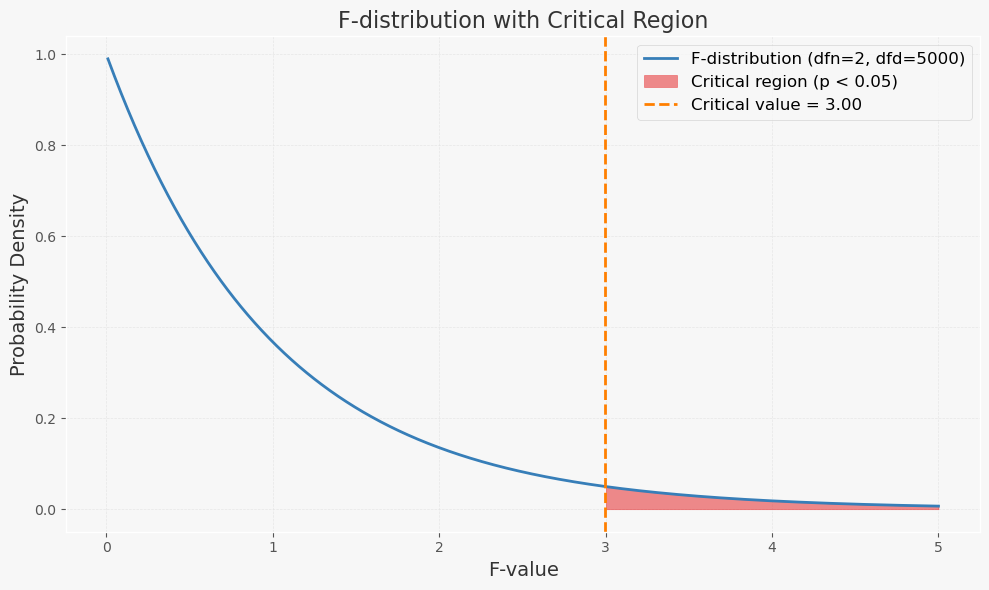

In [39]:
# Enhancing the aesthetic appeal of the graph with better color and style
plt.style.use('ggplot')  # Using 'ggplot' style for better aesthetics

# Degrees of freedom for the numerator and the denominator
dfn, dfd = 2, 5000

# Significance value
alpha = 0.05

# Calculate critical value for alpha = 0.05
critical_value = stats.f.ppf(1 - alpha, dfn, dfd)

# Generate values
x = np.linspace(0.01, 5, 1000)  # Adjusting the range to capture the relevant part of the distribution
y = stats.f.pdf(x, dfn, dfd)

# Plotting with enhanced aesthetics
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='#377eb8', lw=2, label=f'F-distribution (dfn={dfn}, dfd={dfd})')
plt.fill_between(x, y, where=(x >= critical_value), color='#e41a1c', alpha=0.5, label='Critical region (p < 0.05)')
plt.axvline(critical_value, color='#ff7f00', linestyle='dashed', lw=2, label=f'Critical value = {critical_value:.2f}')
plt.title('F-distribution with Critical Region', fontsize=16, color='#333333')
plt.xlabel('F-value', fontsize=14, color='#333333')
plt.ylabel('Probability Density', fontsize=14, color='#333333')
plt.legend(fontsize=12, frameon=True, facecolor='#f7f7f7', edgecolor='#cccccc')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#e0e0e0')
plt.tight_layout()

# Set the background color
ax = plt.gca()
ax.set_facecolor('#f7f7f7')
fig = plt.gcf()
fig.patch.set_facecolor('#f7f7f7')

# Save and show the plot with enhanced aesthetics
plt.show()

In [70]:
raw_data = pd.read_csv("House_Prediction.csv")

# Data Exploration

Based on prior knowledge of the area, we can somewhat expect the values of the house to be along the lines of:

Most expensive districts: District 1, 2, 3, 4, 5, 6, 7,

2nd most expensive: District 8, 9, 10, 11, Binh Tan, Thu Duc, Tan Binh, Tan Phu, Binh Thanh

3rd most expensive: Can Gio, Cu Chi, Go Vap, Hoc Mon, Nha Be, Phu Nhuan

Once again, these are just estimates based on the development of each district, and in each district there could be a large discrepancy between each property.

In [75]:
df1.groupby("district")["district"].agg("count")

district
Bình Chánh     53
Bình Thạnh    198
Bình Tân      195
Cần Giờ         1
Củ Chi          3
Gò Vấp        151
Hóc Môn        15
Nhà Bè         66
Phú Nhuận      87
Quận 1         36
Quận 10       106
Quận 11        34
Quận 12       149
Quận 2        268
Quận 3         42
Quận 4        130
Quận 5         14
Quận 6         96
Quận 7        375
Quận 8         92
Quận 9        148
Thủ Đức       110
Tân Bình      131
Tân Phú       255
Name: district, dtype: int64

In [74]:
# Every time a significant change to the data is made, a new df[i] will be used
# df1: raw unedited data

raw_data.head()
df1 = pd.DataFrame(raw_data)
df1

,district,area,bed,toilet,legal_status,furniture,price
0,Bình Tân,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.00
1,Bình Tân,66.0,2,2,Hợp đồng mua bán,Basic,3.10
2,Tân Phú,85.4,2,2,Sổ đỏ/Sổ hồng,Fully Furnished,4.35
3,Bình Tân,78.0,2,2,Hợp đồng mua bán,Basic,3.50
4,Bình Chánh,82.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.40
...,...,...,...,...,...,...,...
2750,Bình Tân,32.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.55
2751,Bình Thạnh,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.20
2752,Phú Nhuận,28.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.65
2753,Bình Thạnh,60.0,3,2,Sổ đỏ/Sổ hồng,Basic,4.80


The unit for area is m^2, and furniture is classified based on the information in the listing of the property. The concept of legal status will be explained in greater detail later.

## Task 1: Find outliers, clear them

First, we look into box plot graphs of the data and try to find the outliers.

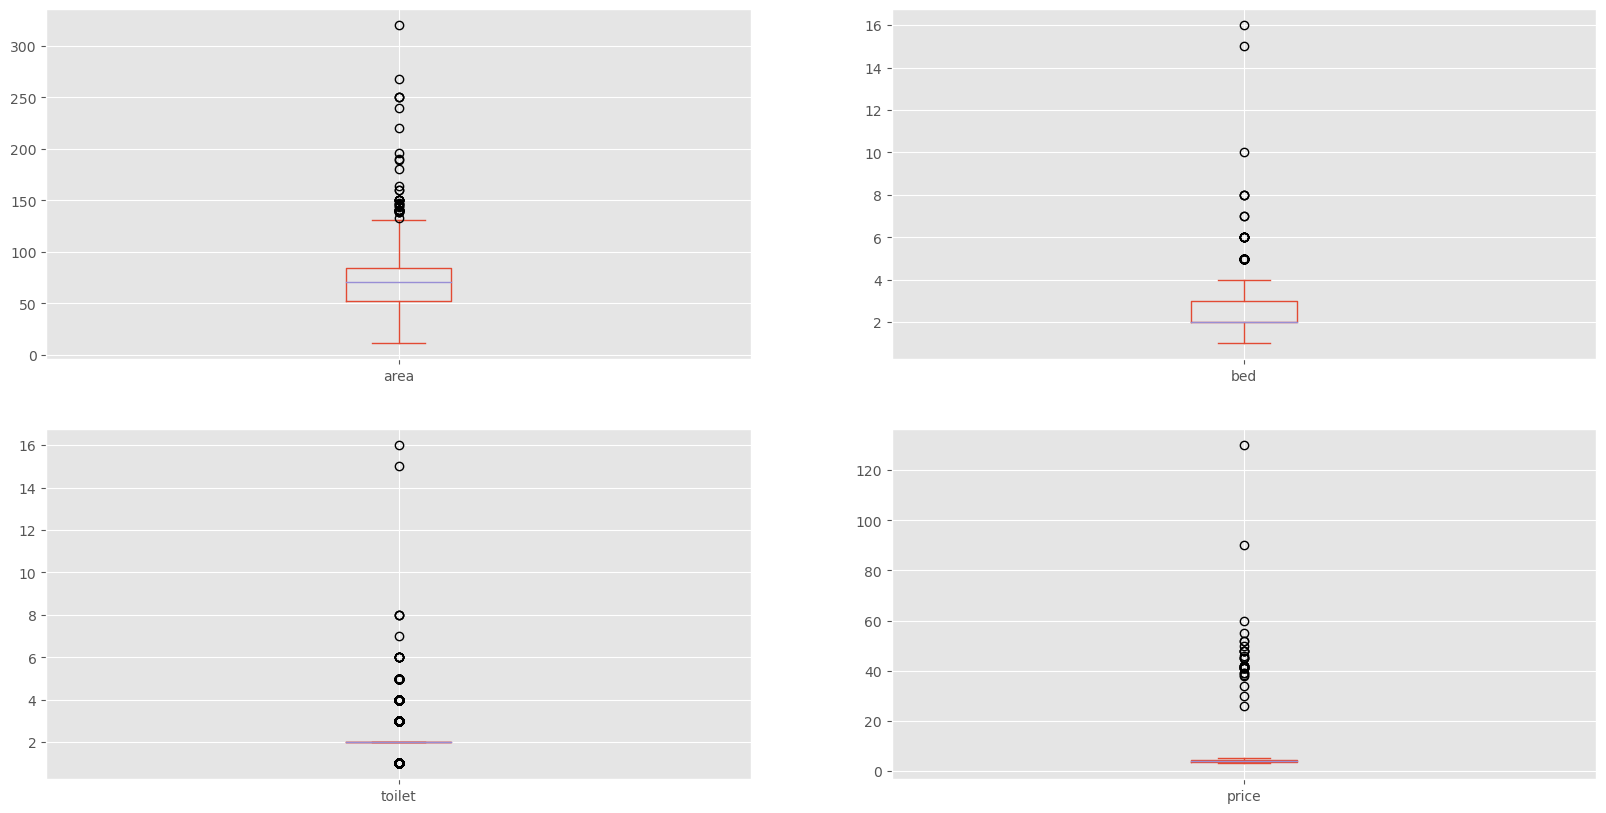

In [77]:
df1.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

As you can see, the extremes of the price graph should be between 3 and 5 as specified by the data collection process, but outliers stretch as far as 120. Therefore, it's necessary to get rid of them and similar outliers in other graphs.

In [115]:
# This values are picked based on the Lower Fence and Upper Fence calculations

df2 = df1[df1['price'] < 6]
df2 = df2[df2['toilet'] < 10]
df2 = df2[df2['bed'] < 9]
df2 = df2[df2['area'] < 150]

There are a lot of Vietnamese homes that are split up into 5m*5m or similarly sized rooms for rent to low-income workers as housing. Although those homes have a lot of rooms and toilets, the fact that they are cheap housing means their cost would throw off the model. Therefore we have decided to remove all houses with more than 9 bedrooms.

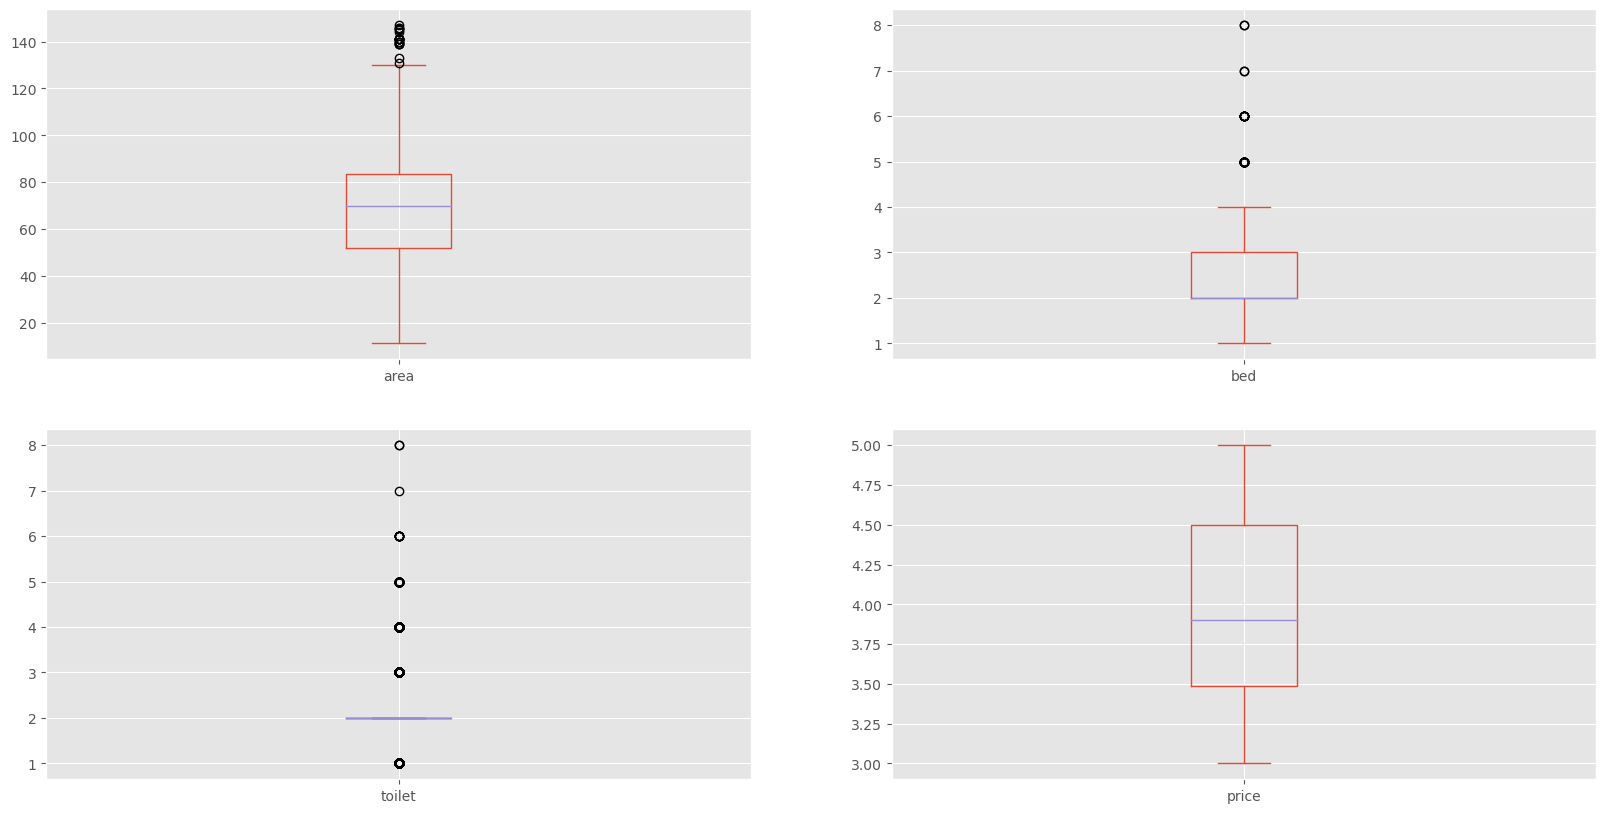

In [117]:
df2.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

Now, I believe the data is already clean of outliers enough. However, that means we have constrained ourselves to predicting houses between 3 and 5 VND billion, with less than 10 toilets and 9 bedrooms and 200 m2 in area. However, this does ensure that our result maintain good accuracy.

Next, we remove houses with number of toilets >= number of bedroom + 2 to maintain data consistency.

In [118]:
df3 = df2[df2['toilet'] <= df2['bed'] + 2]
df3

,district,area,bed,toilet,legal_status,furniture,price
0,Bình Tân,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.00
1,Bình Tân,66.0,2,2,Hợp đồng mua bán,Basic,3.10
2,Tân Phú,85.4,2,2,Sổ đỏ/Sổ hồng,Fully Furnished,4.35
3,Bình Tân,78.0,2,2,Hợp đồng mua bán,Basic,3.50
4,Bình Chánh,82.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.40
...,...,...,...,...,...,...,...
2750,Bình Tân,32.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.55
2751,Bình Thạnh,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.20
2752,Phú Nhuận,28.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.65
2753,Bình Thạnh,60.0,3,2,Sổ đỏ/Sổ hồng,Basic,4.80


In [26]:
df3.groupby('legal_status')['legal_status'].agg("count")

legal_status
Công chứng ngay       10
Hợp đồng mua bán     501
Sổ đỏ/Sổ hồng       2102
Đang chờ sổ           82
Name: legal_status, dtype: int64

Looking at the data for each district, we get:

In [36]:
df3.groupby('district')['district'].agg('count')

district
Bình Chánh     51
Bình Thạnh    197
Bình Tân      185
Củ Chi          2
Gò Vấp        150
Hóc Môn        14
Nhà Bè         56
Phú Nhuận      85
Quận 1         35
Quận 10       106
Quận 11        34
Quận 12       146
Quận 2        266
Quận 3         42
Quận 4        130
Quận 5         14
Quận 6         96
Quận 7        369
Quận 8         90
Quận 9        137
Thủ Đức       105
Tân Bình      131
Tân Phú       254
Name: district, dtype: int64

As we can see, in Can Gio, Cu Chi,... there's very few data about land going on sale there. Therefore, some alterations would have to be made.
1. Data for properties in Hoc Mon would be changed to Quận 12, as they are practically the same area.
2. Other districts with data less than 20 would be aggregated under category "Other"

In [119]:
df4 = df3.replace("Hóc Môn", "Quận 12")
df4.groupby('district')['district'].agg('count')

district
Bình Chánh     51
Bình Thạnh    197
Bình Tân      185
Củ Chi          2
Gò Vấp        150
Nhà Bè         56
Phú Nhuận      85
Quận 1         35
Quận 10       106
Quận 11        34
Quận 12       160
Quận 2        266
Quận 3         42
Quận 4        130
Quận 5         14
Quận 6         96
Quận 7        369
Quận 8         90
Quận 9        137
Thủ Đức       105
Tân Bình      131
Tân Phú       254
Name: district, dtype: int64

In [121]:
df5 = df4.replace('Củ Chi', 'Other')
df5 = df5.replace('Quận 5', 'Other')
df5 = df5.replace('Cần Giờ', 'Other')

In [122]:
df5.groupby('district')['district'].agg('count')

district
Bình Chánh     51
Bình Thạnh    197
Bình Tân      185
Gò Vấp        150
Nhà Bè         56
Other          16
Phú Nhuận      85
Quận 1         35
Quận 10       106
Quận 11        34
Quận 12       160
Quận 2        266
Quận 3         42
Quận 4        130
Quận 6         96
Quận 7        369
Quận 8         90
Quận 9        137
Thủ Đức       105
Tân Bình      131
Tân Phú       254
Name: district, dtype: int64

In [124]:
df5

,district,area,bed,toilet,legal_status,furniture,price
0,Bình Tân,66.0,2,2,Sổ đỏ/Sổ hồng,1,3.00
1,Bình Tân,66.0,2,2,Hợp đồng mua bán,1,3.10
2,Tân Phú,85.4,2,2,Sổ đỏ/Sổ hồng,2,4.35
3,Bình Tân,78.0,2,2,Hợp đồng mua bán,1,3.50
4,Bình Chánh,82.0,2,2,Sổ đỏ/Sổ hồng,1,3.40
...,...,...,...,...,...,...,...
2750,Bình Tân,32.0,2,2,Sổ đỏ/Sổ hồng,1,3.55
2751,Bình Thạnh,66.0,2,2,Sổ đỏ/Sổ hồng,1,3.20
2752,Phú Nhuận,28.0,2,2,Sổ đỏ/Sổ hồng,1,3.65
2753,Bình Thạnh,60.0,3,2,Sổ đỏ/Sổ hồng,1,4.80


## Task 2: Altering the data for model building

Some apartments are already furnished with different tiers of furniture. We can give them a number index, the higher the tier the higher the number.

In [123]:
df5 = df5.replace("Unfurnished", 0)
df5 = df5.replace("Basic", 1)
df5 = df5.replace("Fully Furnished", 2)
df5 = df5.replace("Luxuriously Furnished", 3)

df5.groupby('furniture')['furniture'].agg('count')

furniture
0      82
1     913
2    1556
3     144
Name: furniture, dtype: int64

In [43]:
df5

,district,area,bed,toilet,legal_status,furniture,price
0,Bình Tân,66.0,2,2,Sổ đỏ/Sổ hồng,1,3.00
1,Bình Tân,66.0,2,2,Hợp đồng mua bán,1,3.10
2,Tân Phú,85.4,2,2,Sổ đỏ/Sổ hồng,2,4.35
3,Bình Tân,78.0,2,2,Hợp đồng mua bán,1,3.50
4,Bình Chánh,82.0,2,2,Sổ đỏ/Sổ hồng,1,3.40
...,...,...,...,...,...,...,...
2750,Bình Tân,32.0,2,2,Sổ đỏ/Sổ hồng,1,3.55
2751,Bình Thạnh,66.0,2,2,Sổ đỏ/Sổ hồng,1,3.20
2752,Phú Nhuận,28.0,2,2,Sổ đỏ/Sổ hồng,1,3.65
2753,Bình Thạnh,60.0,3,2,Sổ đỏ/Sổ hồng,1,4.80


In [127]:
# Converting the District information into True/False format so that the algorithms could
# process the data, using pd.get_dummies

dummies_legal = pd.get_dummies(df5["legal_status"])
dummies_district = pd.get_dummies(df5["district"])

dummies_district

,Bình Chánh,Bình Thạnh,Bình Tân,Gò Vấp,Nhà Bè,Other,Phú Nhuận,Quận 1,Quận 10,Quận 11,...,Quận 2,Quận 3,Quận 4,Quận 6,Quận 7,Quận 8,Quận 9,Thủ Đức,Tân Bình,Tân Phú
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2751,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2752,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2753,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
# Dropping the legal status and district column and stitching the dummies into the data.

df6 = df5.drop('legal_status', axis = 'columns')
df6 = df6.drop('district', axis = 'columns')
df7 = pd.concat([df6, dummies_legal, dummies_district], axis = "columns")


#Debugging df7 = pd.concat([df6, dummies_district], axis = "columns")

In [129]:
# Checking that the data contains all of the needed columns
df7.keys()

Index(['area', 'bed', 'toilet', 'furniture', 'price', 'Công chứng ngay',
       'Hợp đồng mua bán', 'Sổ đỏ/Sổ hồng', 'Đang chờ sổ', 'Bình Chánh',
       'Bình Thạnh', 'Bình Tân', 'Gò Vấp', 'Nhà Bè', 'Other', 'Phú Nhuận',
       'Quận 1', 'Quận 10', 'Quận 11', 'Quận 12', 'Quận 2', 'Quận 3', 'Quận 4',
       'Quận 6', 'Quận 7', 'Quận 8', 'Quận 9', 'Thủ Đức', 'Tân Bình',
       'Tân Phú'],
      dtype='object')

In [76]:
df7.head()

,area,bed,toilet,furniture,price,Công chứng ngay,Hợp đồng mua bán,Sổ đỏ/Sổ hồng,Đang chờ sổ,Bình Chánh,...,Quận 2,Quận 3,Quận 4,Quận 6,Quận 7,Quận 8,Quận 9,Thủ Đức,Tân Bình,Tân Phú
0,66.0,2,2,1,3.00,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,66.0,2,2,1,3.10,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,85.4,2,2,2,4.35,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,78.0,2,2,1,3.50,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,82.0,2,2,1,3.40,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


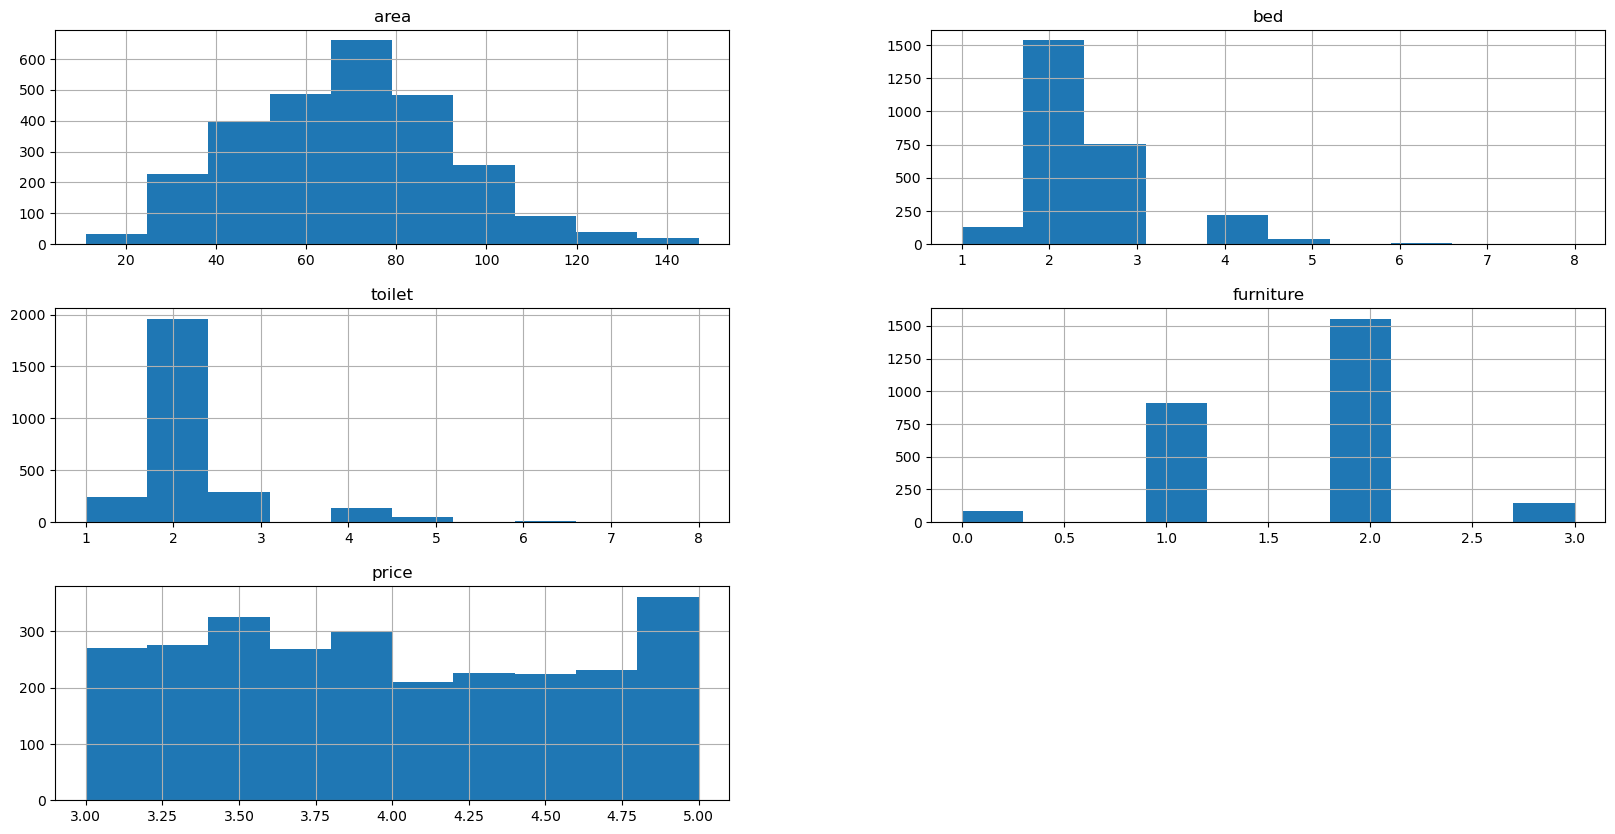

In [68]:
#Viewing the data after processing. This is the histogram of the data

df7.hist()
plt.show()

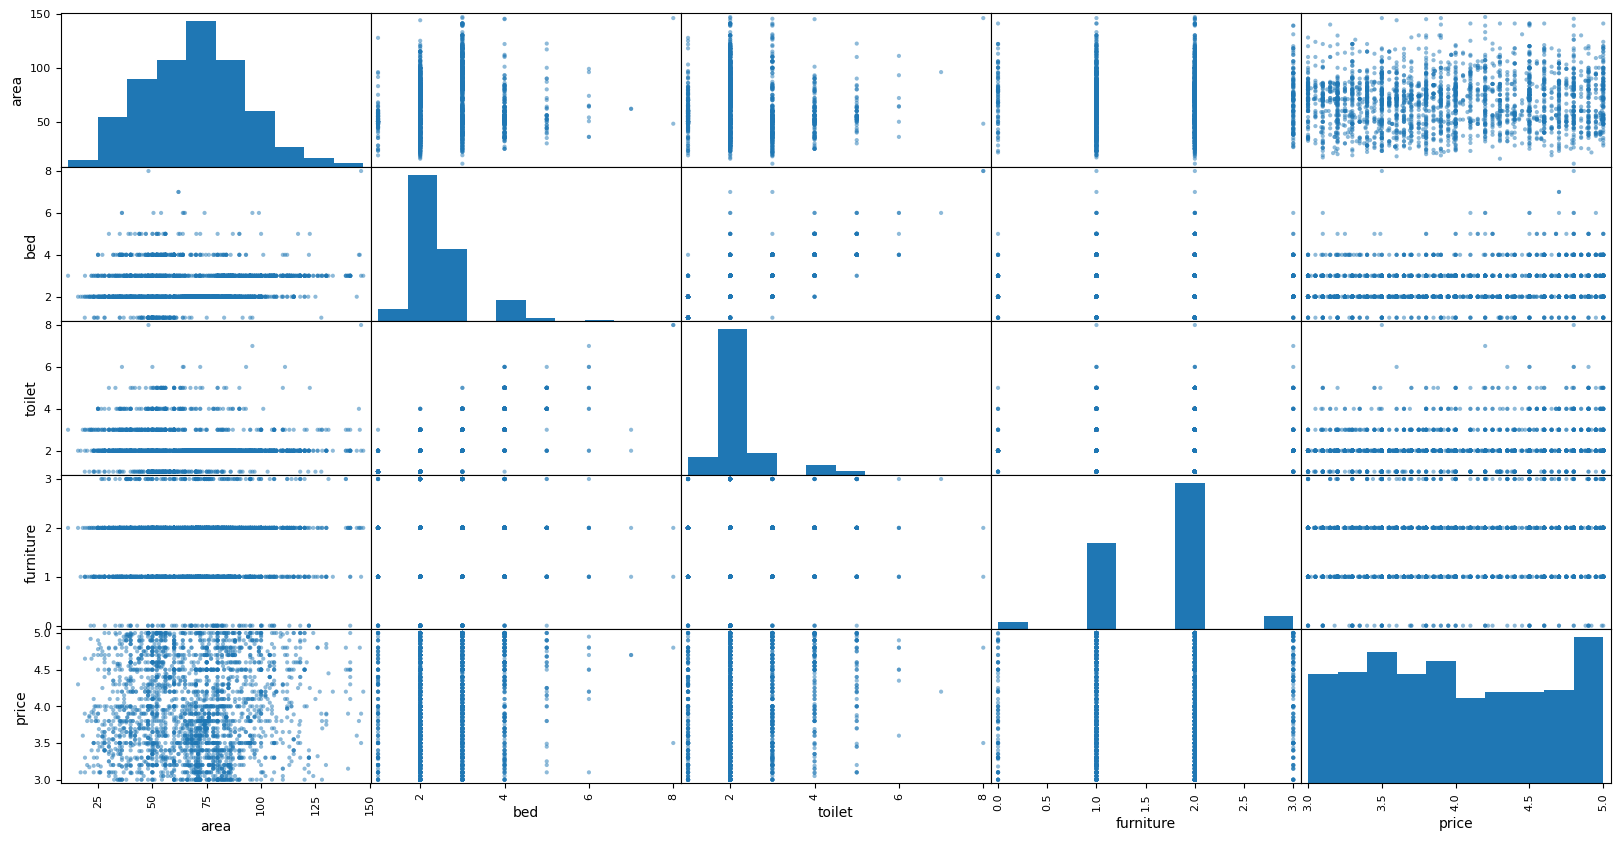

In [69]:
scatter_matrix(df6)
plt.show()

## Model Building

Welcome to the championship of training models! Here are our contestants:
    
    Linear Regression (lr_clf)
    
    Lasso Regression (lasso_model)
    
    SVMs (svm_clf)
    
    Gradient Boosting Regression (gboost_clf)
    
    Random Forest Regression (rf_clf)
    
    Decision Tree Regressor (dt_clf)
    
    Gaussian Process Regressor (gnr_clf)
    
    Ada Boost Regressor (abc_clf)
    
That's a lot! Let's hope they produce great results. 

First we have to prepare the X set (independent attributes, i.e. input to the model) and the y set (the dependent attribute, cost in this case). X and y will be further split into 2 of proportion 8:2 for training:testing.

In [183]:
X = df7.drop("price", axis = "columns")
y = df7.price

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

First, let's start with linear regression.

In [83]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
predictions =  lr_clf.predict(X_test)

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 
# model evaluation 
print( 
  'mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print( 
  'mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 
print(lr_clf.score(X_test, y_test))

mean_squared_error :  0.3217948499912599
mean_absolute_error :  0.4809976329737468
0.10363304532381212


In [95]:
cross_val_score(lr_clf, X, y, cv=10)

array([0.1175601 , 0.13515667, 0.05937967, 0.12396445, 0.12081981,
       0.20597785, 0.1442722 , 0.04634627, 0.07507036, 0.06908404])

Ouch. That is a very bad score. It's not like he even tried! Let's see how the other models do:

In [101]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha = 1.0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_model.fit(X_train, y_train)
lasso_model.score(X_test, y_test)

-4.498941652553157e-06

In [99]:
cross_val_score(lasso_model, X, y, cv=10)

array([-3.96470542e-03, -1.98082458e-03, -9.53806458e-03, -2.53388279e-03,
       -1.58333945e-05, -1.99391102e-04, -5.51277149e-04, -3.03543367e-03,
       -1.99698701e-02, -1.62459135e-03])

# THAT'S EVEN WORSE! HOW COULD THIS BE!

In [100]:
from sklearn import svm
svm_clf = svm.SVR()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.026129212064605056

In [133]:
cross_val_score(svm_clf, X, y, cv=10)

array([0.03769872, 0.08969036, 0.04598957, 0.02072351, 0.03126663,
       0.11223437, 0.06227996, 0.00869521, 0.01319457, 0.04459971])

And it does not get much better from here.

In [105]:
>>> from sklearn.ensemble import GradientBoostingRegressor
gboost_clf = GradientBoostingRegressor(random_state = 1)
gboost_clf.fit(X_train, y_train)
gboost_clf.score(X_test, y_test)

0.1988535781235321

In [106]:
cross_val_score(gboost_clf, X, y, cv=10)

array([0.21736135, 0.20871965, 0.20343348, 0.25807154, 0.18259082,
       0.27487208, 0.19828252, 0.13885409, 0.1882858 , 0.17624659])

Random Forest

In [107]:
>>> from sklearn.ensemble import RandomForestRegressor
rf_clf = RandomForestRegressor(random_state = 1)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.2861172691681224

In [109]:
cross_val_score(rf_clf, X, y, cv=10)

array([0.293848  , 0.31443259, 0.26451837, 0.43686842, 0.26836458,
       0.25497335, 0.2649589 , 0.13743112, 0.16332063, 0.14638976])

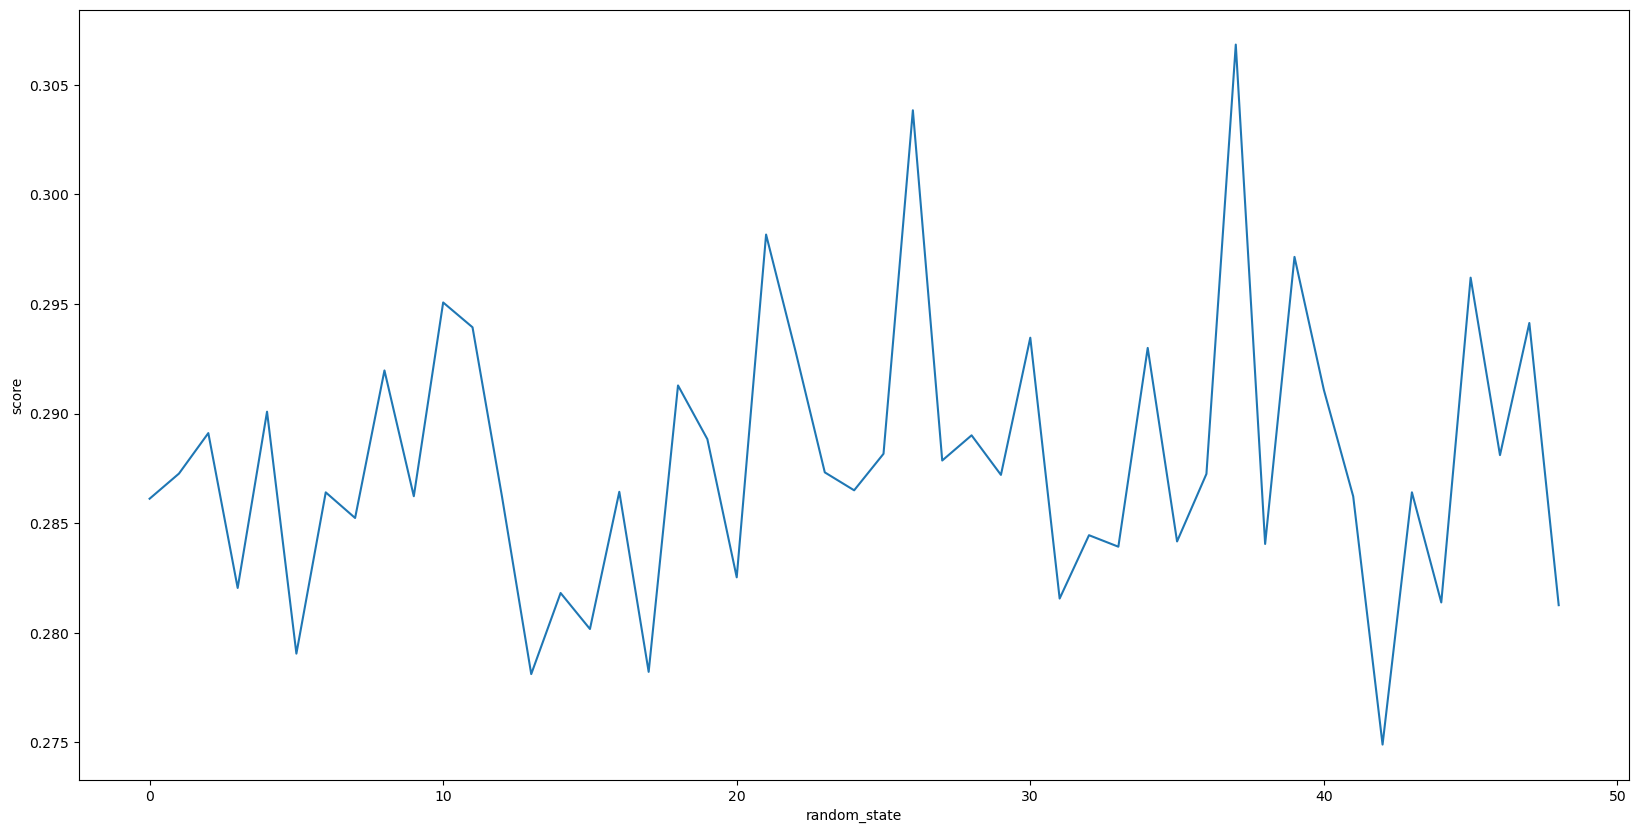

In [113]:
# We don't know which random_state works best. Maybe we can find out this way?
rf_score_list = []
for i in range(1, 50):
    rf_clf = RandomForestRegressor(random_state = i)
    rf_clf.fit(X_train, y_train)
    rf_score_list.append(rf_clf.score(X_test, y_test))

plt.plot(rf_score_list)
plt.xlabel('random_state')
plt.ylabel('score')

plt.show()

This little maneuver took us 51 years. Anyhow, it's so bad I would love to abandon this project this second.

Decision Tree

In [114]:
# We know it's gonna be terrible, so we will just make a plot of the score for each max depth from 1 to 50.

from sklearn.tree import DecisionTreeRegressor
score_list = []
for i in range(1, 50):
    dt_clf = DecisionTreeRegressor(max_depth = i)
    dt_clf.fit(X_train, y_train)
    score_list.append(dt_clf.score(X_test, y_test))

In [115]:
# Yep it is bad.
dt_clf.score(X_test, y_test)

-0.10425587636326439

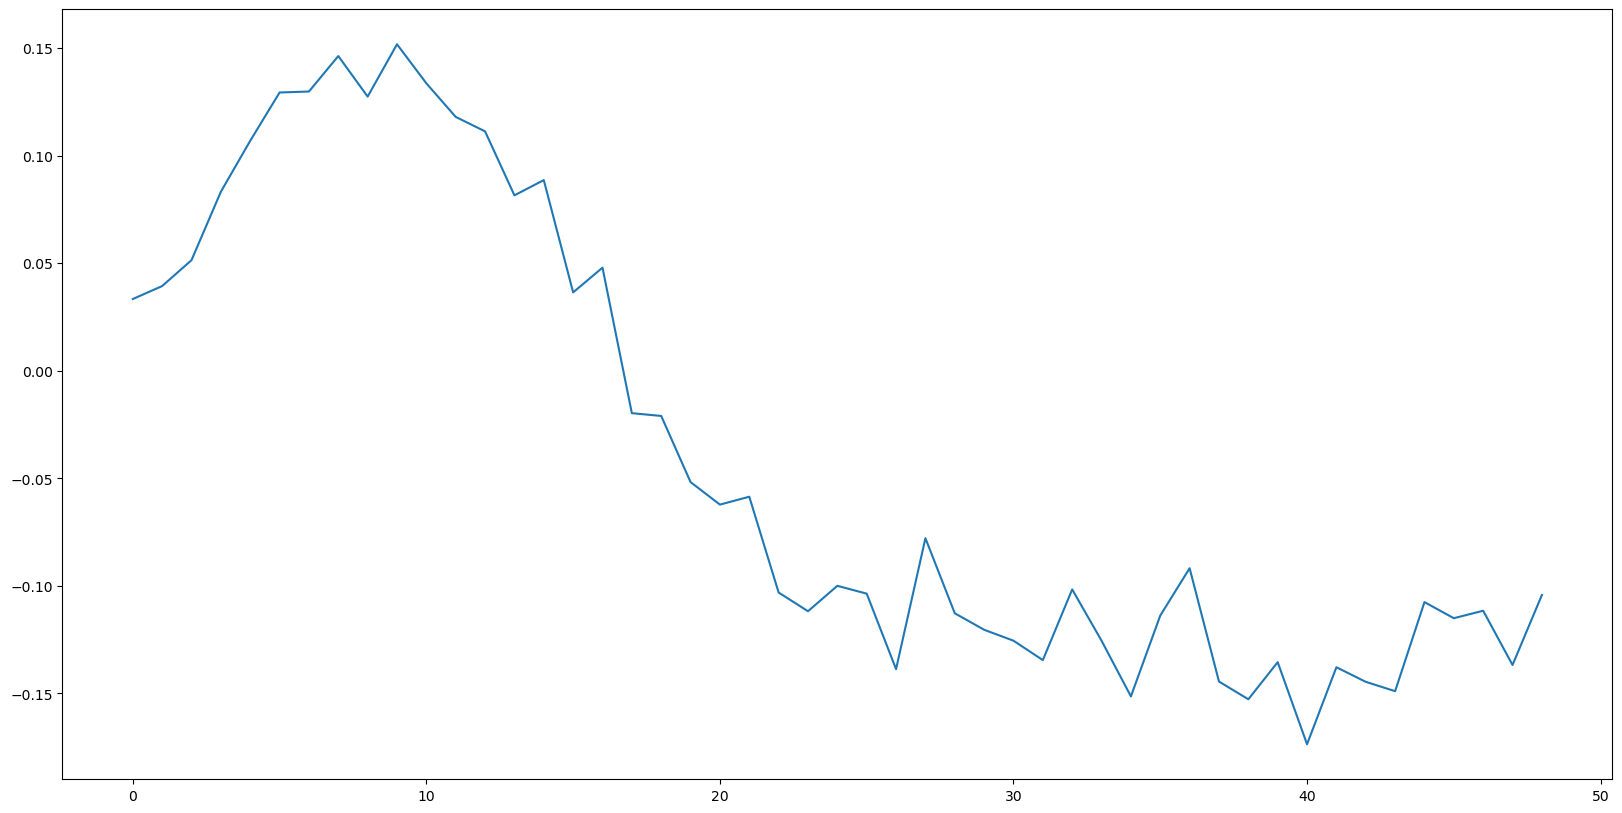

In [116]:
plt.plot(score_list)
plt.show()

What's even going on? Let's see the results of the last 2, starting with GaussianProcessRegressor.

In [117]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [118]:
gnr_clf = GaussianProcessRegressor()
gnr_clf.fit(X_train, y_train)
gnr_clf.score(X_test, y_test)

-2.647267341777287

In [119]:
cross_val_score(gnr_clf, X, y, cv=10)
# All negatives? That's record breaking accuracy!

array([-2.46409118, -2.91709581, -2.35553682, -4.13920837, -2.54767117,
       -2.1598558 , -3.29485099, -2.68505288, -3.29202495, -3.40535238])

Last one is Ada Boost Regressor.

In [121]:
from sklearn.ensemble import AdaBoostRegressor
abc_clf = AdaBoostRegressor(n_estimators=100)
abc_clf.fit(X_train, y_train)
abc_clf.score(X_test, y_test)

0.06918585209951567

In [122]:
cross_val_score(abc_clf, X, y, cv=10)
# Let's not even look at this

array([0.06199137, 0.0760794 , 0.05862976, 0.09163634, 0.06991695,
       0.11923552, 0.09554092, 0.05784374, 0.07293411, 0.07962107])

### What happened?
I honestly had zero idea. Tried new stuff, changed old stuff, etc.
I began looking at existing dataset to see if there's anything wrong with our current procedure.
Before that, let's look at Rachel's approach. - Dat

# Rachel's Approach:
Note: I have adapted the data to run seamlessly in the same NB file as me by adding the suffix `_ha` in front of all objects and variables in the following code. (Dat)

In [123]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Loading the dataset and looking at its properties

In [82]:
# Load the dataset
data = pd.read_csv("House_Prediction.csv")

# Initial exploration
print(data.describe())
print(data.info())

              area          bed       toilet        price
count  2755.000000  2755.000000  2755.000000  2755.000000
mean     70.337564     2.478766     2.211615     4.474980
std      25.874329     0.910582     0.875228     5.096708
min      11.200000     1.000000     1.000000     3.000000
25%      52.000000     2.000000     2.000000     3.500000
50%      71.000000     2.000000     2.000000     3.900000
75%      84.000000     3.000000     2.000000     4.500000
max     320.000000    16.000000    16.000000   130.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   district      2755 non-null   object 
 1   area          2755 non-null   float64
 2   bed           2755 non-null   int64  
 3   toilet        2755 non-null   int64  
 4   legal_status  2755 non-null   object 
 5   furniture     2755 non-null   object 
 6   price         2755 non-

## Visualizing the data

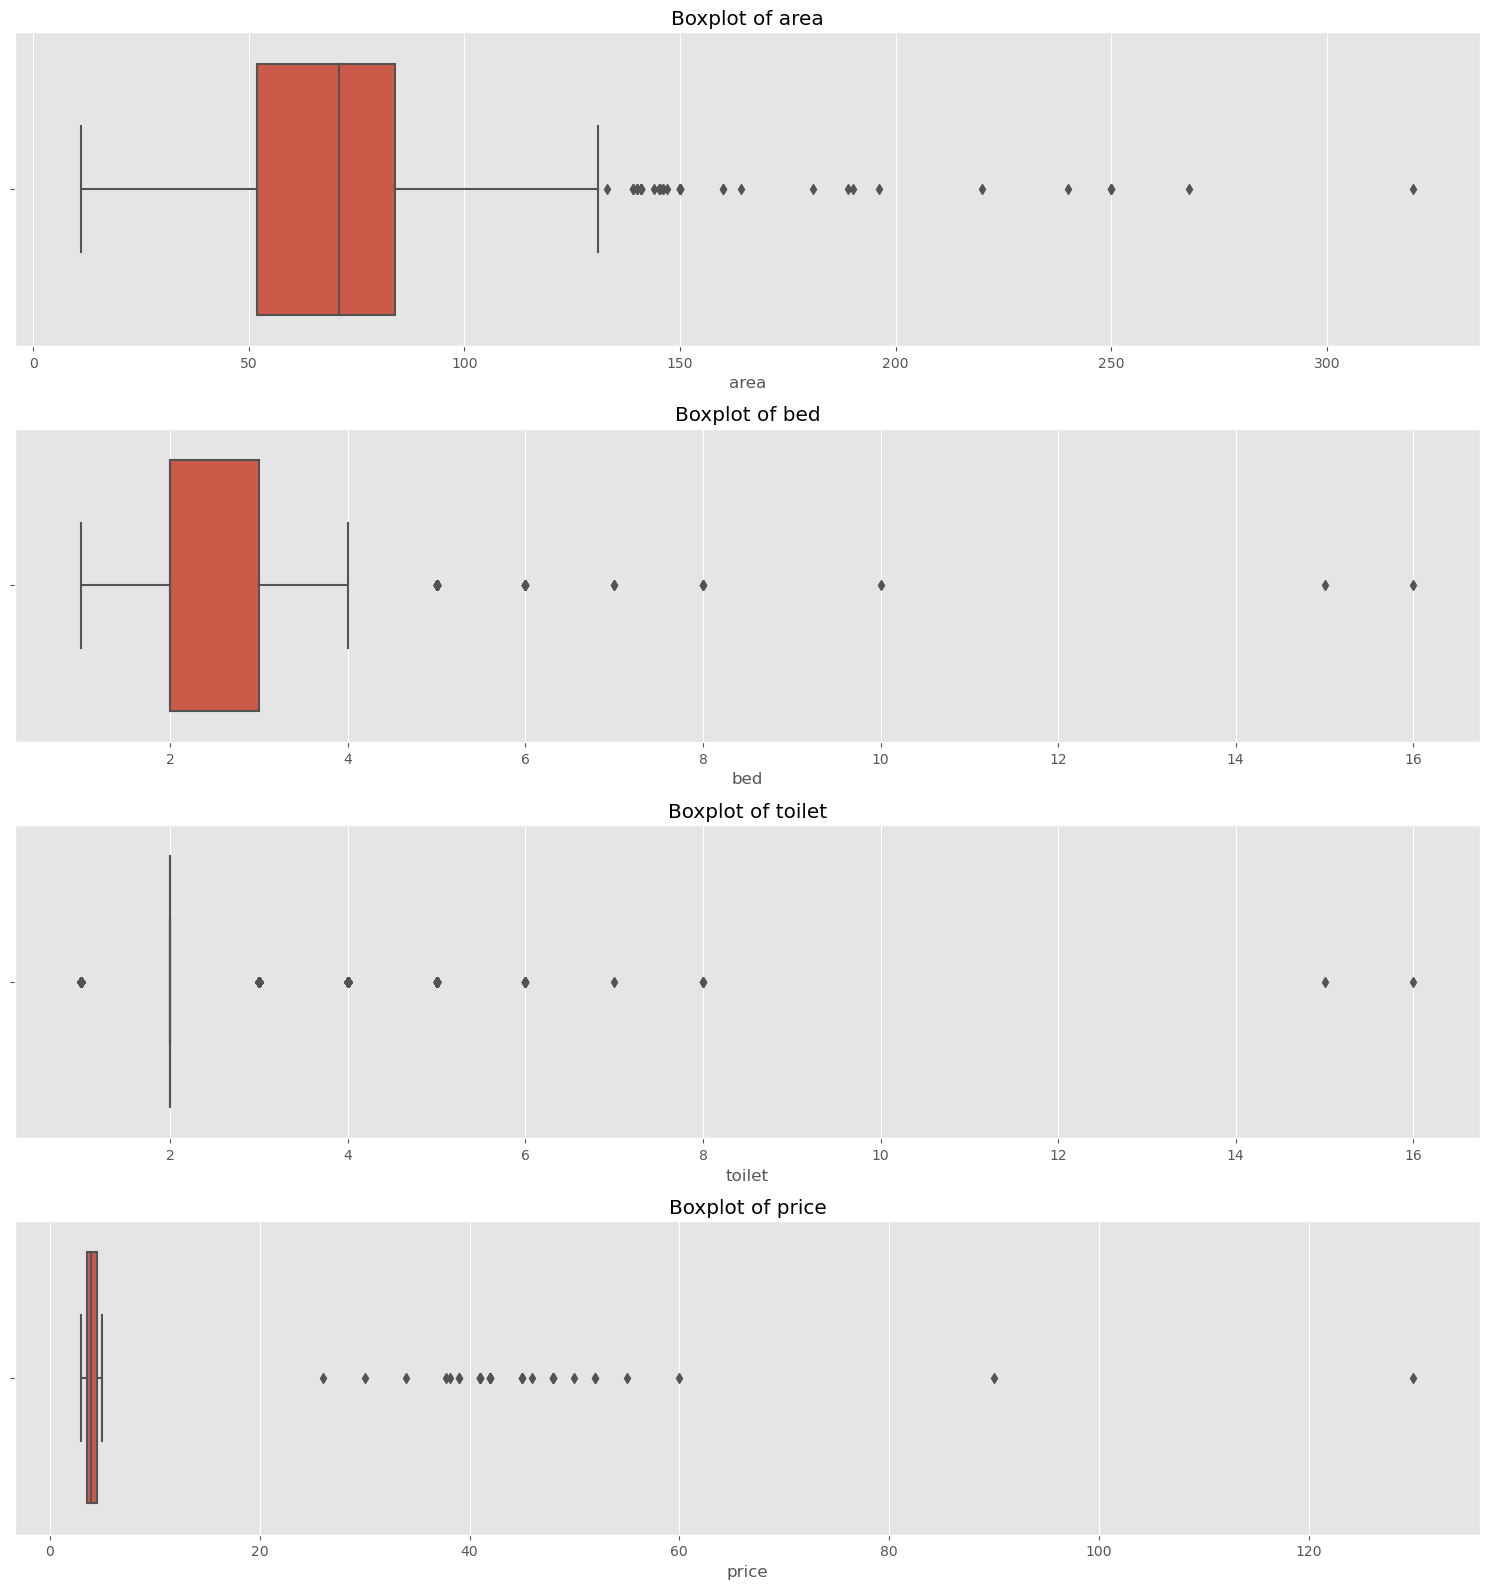

In [83]:
# Function to plot boxplots for each numerical feature to identify outliers
def plot_boxplots(dataframe):
    numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    dataframe = dataframe[numerical_cols]
    n = len(numerical_cols)
    plt.figure(figsize=(15, n * 4))
    
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(n, 1, i)
        sns.boxplot(x=dataframe[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plot_boxplots(data)

## Getting rid of outliers

In [84]:


# Detecting and handling outliers (using IQR)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'data' is your DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]




C:\Users\DELL\AppData\Local\Temp\ipykernel_19844\2203518920.py:8: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19844\2203518920.py:9: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19844\2203518920.py:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [85]:
data.describe()

,area,bed,toilet,price
count,2755.000000,2755.000000,2755.000000,2755.000000
mean,70.337564,2.478766,2.211615,4.474980
std,25.874329,0.910582,0.875228,5.096708
min,11.200000,1.000000,1.000000,3.000000
25%,52.000000,2.000000,2.000000,3.500000
50%,71.000000,2.000000,2.000000,3.900000
75%,84.000000,3.000000,2.000000,4.500000
max,320.000000,16.000000,16.000000,130.000000


## Use logarithmic transformation to minimize the impact of outliers on results

In [86]:
# Applying logarithmic transformation to 'area' and 'price'
data['log_area'] = np.log1p(data['area'])
data['log_price'] = np.log1p(data['price'])
data

,district,area,bed,toilet,legal_status,furniture,price,log_area,log_price
0,Bình Tân,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.00,4.204693,1.386294
1,Bình Tân,66.0,2,2,Hợp đồng mua bán,Basic,3.10,4.204693,1.410987
2,Tân Phú,85.4,2,2,Sổ đỏ/Sổ hồng,Fully Furnished,4.35,4.458988,1.677097
3,Bình Tân,78.0,2,2,Hợp đồng mua bán,Basic,3.50,4.369448,1.504077
4,Bình Chánh,82.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.40,4.418841,1.481605
...,...,...,...,...,...,...,...,...,...
2750,Bình Tân,32.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.55,3.496508,1.515127
2751,Bình Thạnh,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.20,4.204693,1.435085
2752,Phú Nhuận,28.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.65,3.367296,1.536867
2753,Bình Thạnh,60.0,3,2,Sổ đỏ/Sổ hồng,Basic,4.80,4.110874,1.757858


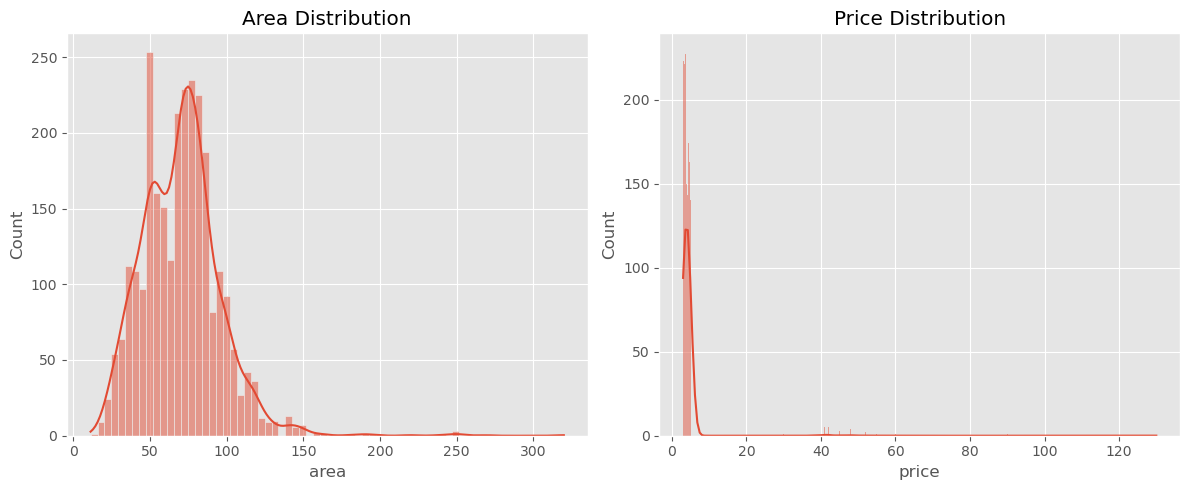

In [87]:
# Checking the distribution of 'area' and 'price'
plt.figure(figsize=(12, 5))

# Plotting distribution of 'area'
plt.subplot(1, 2, 1)
sns.histplot(data['area'], kde=True)
plt.title('Area Distribution')

# Plotting distribution of 'price'
plt.subplot(1, 2, 2)
sns.histplot(data['price'], kde=True)
plt.title('Price Distribution')

plt.tight_layout()
plt.show()


In [140]:
data

,district,area,bed,toilet,legal_status,furniture,price,log_area,log_price
0,Bình Tân,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.00,4.204693,1.386294
1,Bình Tân,66.0,2,2,Hợp đồng mua bán,Basic,3.10,4.204693,1.410987
2,Tân Phú,85.4,2,2,Sổ đỏ/Sổ hồng,Fully Furnished,4.35,4.458988,1.677097
3,Bình Tân,78.0,2,2,Hợp đồng mua bán,Basic,3.50,4.369448,1.504077
4,Bình Chánh,82.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.40,4.418841,1.481605
...,...,...,...,...,...,...,...,...,...
2750,Bình Tân,32.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.55,3.496508,1.515127
2751,Bình Thạnh,66.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.20,4.204693,1.435085
2752,Phú Nhuận,28.0,2,2,Sổ đỏ/Sổ hồng,Basic,3.65,3.367296,1.536867
2753,Bình Thạnh,60.0,3,2,Sổ đỏ/Sổ hồng,Basic,4.80,4.110874,1.757858


In [88]:
# One-hot encoding for categorical variables
data_encoded = pd.get_dummies(data, columns=['district', 'legal_status', 'furniture'])

data_encoded

,area,bed,toilet,price,log_area,log_price,district_Bình Chánh,district_Bình Thạnh,district_Bình Tân,district_Cần Giờ,...,district_Tân Bình,district_Tân Phú,legal_status_Công chứng ngay,legal_status_Hợp đồng mua bán,legal_status_Sổ đỏ/Sổ hồng,legal_status_Đang chờ sổ,furniture_Basic,furniture_Fully Furnished,furniture_Luxuriously Furnished,furniture_Unfurnished
0,66.0,2,2,3.00,4.204693,1.386294,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
1,66.0,2,2,3.10,4.204693,1.410987,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,85.4,2,2,4.35,4.458988,1.677097,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,78.0,2,2,3.50,4.369448,1.504077,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,82.0,2,2,3.40,4.418841,1.481605,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,32.0,2,2,3.55,3.496508,1.515127,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
2751,66.0,2,2,3.20,4.204693,1.435085,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2752,28.0,2,2,3.65,3.367296,1.536867,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2753,60.0,3,2,4.80,4.110874,1.757858,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


In [89]:
# Dropping the original 'area' and 'price' columns
data_encoded.drop(['area'], axis=1, inplace=True)

# Displaying the first few rows of the transformed dataset
data_encoded_head = data_encoded.head()


In [90]:
# Splitting the dataset into the Training set and Test set

X_ha = data_encoded.drop(['log_price'], axis=1)
y_ha = data_encoded['log_price']
X_train_ha, X_test_ha, y_train_ha, y_test_ha = train_test_split(X_ha, y_ha, test_size=0.25, random_state=42)

In [142]:
X_ha.keys()

Index(['bed', 'toilet', 'price', 'log_area', 'district_Bình Chánh',
       'district_Bình Thạnh', 'district_Bình Tân', 'district_Củ Chi',
       'district_Gò Vấp', 'district_Hóc Môn', 'district_Nhà Bè',
       'district_Phú Nhuận', 'district_Quận 1', 'district_Quận 10',
       'district_Quận 11', 'district_Quận 12', 'district_Quận 2',
       'district_Quận 3', 'district_Quận 4', 'district_Quận 5',
       'district_Quận 6', 'district_Quận 7', 'district_Quận 8',
       'district_Quận 9', 'district_Thủ Đức', 'district_Tân Bình',
       'district_Tân Phú', 'legal_status_Công chứng ngay',
       'legal_status_Hợp đồng mua bán', 'legal_status_Sổ đỏ/Sổ hồng',
       'legal_status_Đang chờ sổ', 'furniture_Basic',
       'furniture_Fully Furnished', 'furniture_Luxuriously Furnished',
       'furniture_Unfurnished'],
      dtype='object')

## Begin model training

In [144]:
lr_model_ha = LinearRegression()
lr_model_ha.fit(X_train_ha, y_train_ha)
lr_predictions_ha = lr_model_ha.predict(X_test_ha)

In [145]:
# Evaluating the Linear Regression Model
lr_r2_ha = r2_score(y_test_ha, lr_predictions_ha)
lr_rmse_ha = np.sqrt(mean_squared_error(y_test_ha, lr_predictions_ha))

# Output the performance metrics
lr_performance_ha = {'Linear Regression R2 Score': lr_r2_ha, 'Linear Regression RMSE': lr_rmse_ha}
lr_performance_ha

{'Linear Regression R2 Score': 0.9969486715964402,
 'Linear Regression RMSE': 0.006753143250585238}

99% accuracy??? Is this the real life? Is this just fantasy?

In [172]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr_model_ha, X_ha, y_ha, cv=5)

array([0.99705936, 0.99710191, 0.99703808, 0.99694074, 0.99700997])

This was so high that I couldn't believe my own eyes (and literally so because it was 12:30 in the morning. Next is SVM

In [95]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

# Building and Training the SVM Model
svm_model_ha = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model_ha.fit(X_train_ha, y_train_ha)
svm_predictions_ha = svm_model_ha.predict(X_test_ha)

In [174]:
# Evaluating the SVM Model
svm_r2_ha = r2_score(y_test_ha, svm_predictions_ha)
svm_rmse_ha = np.sqrt(mean_squared_error(y_test_ha, svm_predictions_ha))

# Output the performance metrics
svm_performance_ha = {'SVM R2 Score': svm_r2_ha, 'SVM RMSE': svm_rmse_ha}

svm_performance_ha

{'SVM R2 Score': 0.7631196304913044, 'SVM RMSE': 0.059501240800217584}

Not as high, but still quite substantial. I wonder how the next few will perform?

In [150]:
# Building and Training the Random Forest Model
rf_model_ha = RandomForestRegressor(n_estimators=2, random_state=10)
rf_model_ha.fit(X_train_ha, y_train_ha)
rf_predictions_ha = rf_model_ha.predict(X_test_ha)

# Evaluating the Random Forest Model
rf_r2_ha = r2_score(y_test_ha, rf_predictions_ha)
rf_rmse_ha = np.sqrt(mean_squared_error(y_test_ha, rf_predictions_ha))

# Output the performance metrics
rf_performance_ha = {'Random Forest R2 Score': rf_r2_ha, 'Random Forest RMSE': rf_rmse_ha}

rf_performance_ha

{'Random Forest R2 Score': 0.9999845832429509,
 'Random Forest RMSE': 0.00048001852779215056}

99.99% accuracy. We've struck 24K gold!

In [176]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Building and Training the Decision Tree Model
dt_model_ha = DecisionTreeRegressor(random_state=42)
dt_model_ha.fit(X_train_ha, y_train_ha)
dt_predictions_ha = dt_model_ha.predict(X_test_ha)

# Evaluating the Decision Tree Model
dt_r2_ha = r2_score(y_test_ha, dt_predictions_ha)
dt_rmse_ha = np.sqrt(mean_squared_error(y_test_ha, dt_predictions_ha))

# Output the performance metrics
dt_performance_ha = {'Decision Tree R2 Score': dt_r2_ha, 'Decision Tree RMSE': dt_rmse_ha}

dt_performance_ha

{'Decision Tree R2 Score': 0.9999885866443321,
 'Decision Tree RMSE': 0.0004130172226860974}

The prediction rate of these models are pretty consistently high. This should be legit right?

In [158]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb # if you encounter an error running this code, run pip install xgboost first

# Building and Training the XGBoost Gradient Boosting Model
xgb_model_ha = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_ha.fit(X_train_ha, y_train_ha)
xgb_predictions_ha = xgb_model_ha.predict(X_test_ha)

# Evaluating the XGBoost Gradient Boosting Model
xgb_r2_ha = r2_score(y_test_ha, xgb_predictions_ha)
xgb_rmse_ha = np.sqrt(mean_squared_error(y_test_ha, xgb_predictions_ha))

# Output the performance metrics
xgb_performance_ha = {'XGBoost R2 Score': xgb_r2_ha, 'XGBoost RMSE': xgb_rmse_ha}

xgb_performance_ha

{'XGBoost R2 Score': 0.9999723894183493, 'XGBoost RMSE': 0.0006423907285172571}

In [160]:
from sklearn.model_selection import cross_validate

# Cross-validation for Linear Regression
lr_scoring_ha = ['r2', 'neg_mean_squared_error']
lr_scores_ha = cross_validate(lr_model_ha, X_ha, y_ha, cv=5, scoring=lr_scoring_ha)
lr_mean_r2_ha = lr_scores_ha['test_r2'].mean()
lr_mean_mse_ha = -lr_scores_ha['test_neg_mean_squared_error'].mean()
print("Linear Regression Cross-validated R² score:", lr_mean_r2_ha)
print("Linear Regression Cross-validated MSE:", lr_mean_mse_ha)

# Cross-validation for Random Forest
rf_scoring_ha = ['r2', 'neg_mean_squared_error']
rf_scores_ha = cross_validate(rf_model_ha, X_ha, y_ha, cv=5, scoring=rf_scoring_ha)
rf_mean_r2_ha = rf_scores_ha['test_r2'].mean()
rf_mean_mse_ha = -rf_scores_ha['test_neg_mean_squared_error'].mean()
print("Random Forest Cross-validated R² score:", rf_mean_r2_ha)
print("Random Forest Cross-validated MSE:", rf_mean_mse_ha)

Linear Regression Cross-validated R² score: 0.9970300106954235
Linear Regression Cross-validated MSE: 4.430913195046562e-05
Random Forest Cross-validated R² score: 0.9999887436841004
Random Forest Cross-validated MSE: 1.6749980026854624e-07


All of the models give really good results. Let's plot them to see how good it matches our sample data.

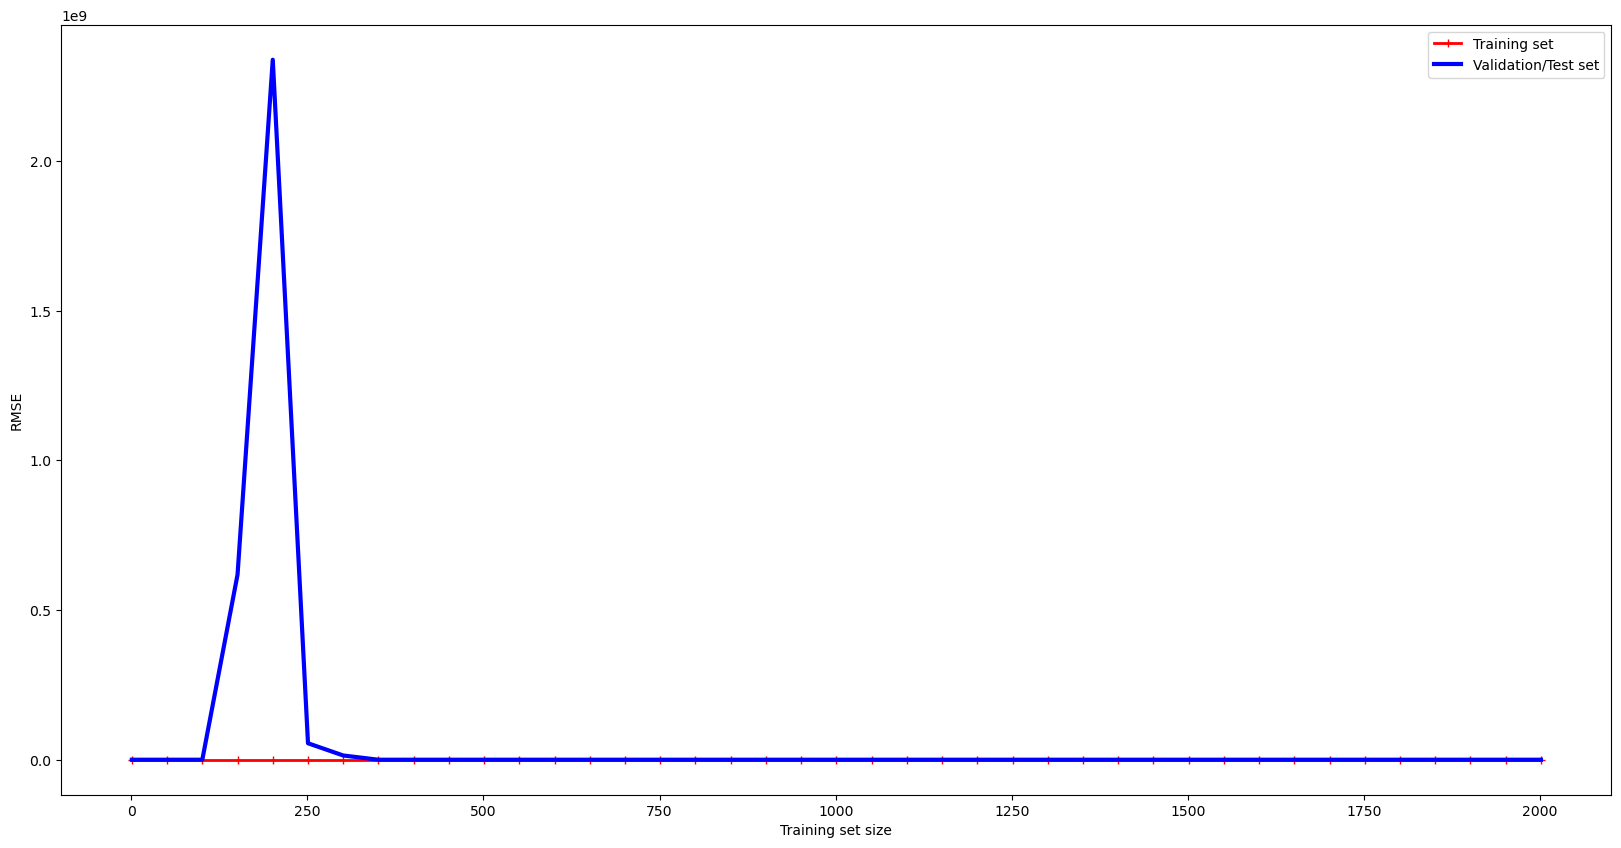

In [161]:
# Plot learning curves
def plot_learning_curves(model, X_train, y_train, X_test, y_test):
    train_errors, val_errors = [], []
    sizes = np.arange(1, len(X_train) + 1, 50)

    for m in sizes:
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_test_pred = model.predict( X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error( y_test, y_test_pred))

    plt.plot(sizes, np.sqrt(train_errors), "r-+", linewidth=2, label="Training set")
    plt.plot(sizes, np.sqrt(val_errors), "b-", linewidth=3, label="Validation/Test set")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc="upper right")
    plt.show()

# Plot learning curves
plot_learning_curves(lr_model_ha, X_train_ha, y_train_ha, X_test_ha, y_test_ha)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

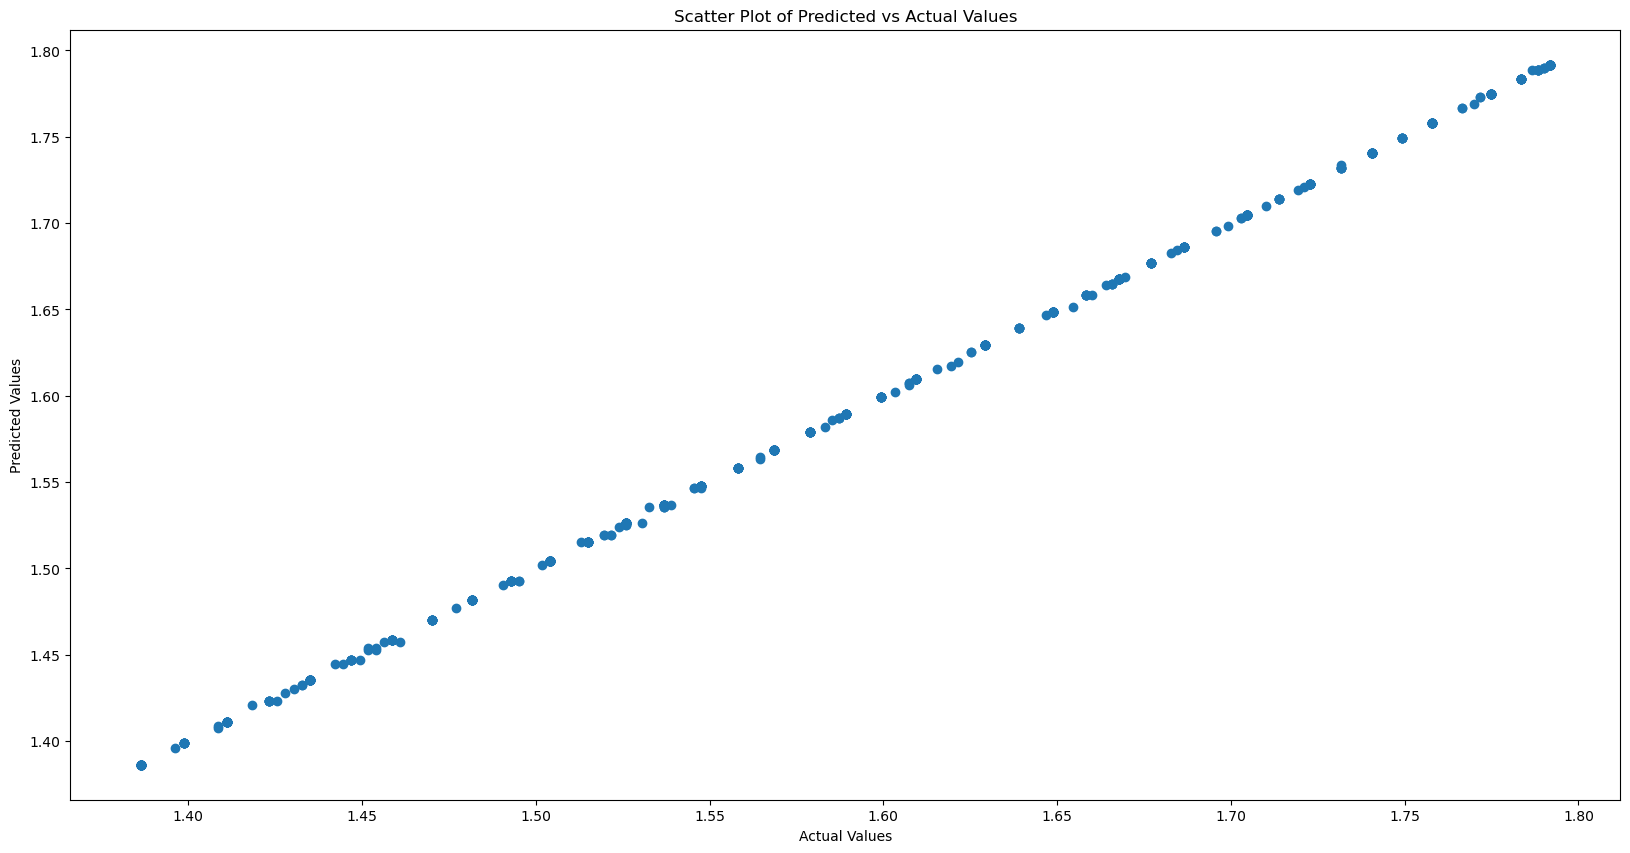

In [162]:
# Create the scatter plot
plt.scatter(y_test_ha, rf_predictions_ha)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')

# Display the plot
plt.show()

That line is really straight. A linear regression model would thread the needle right through!

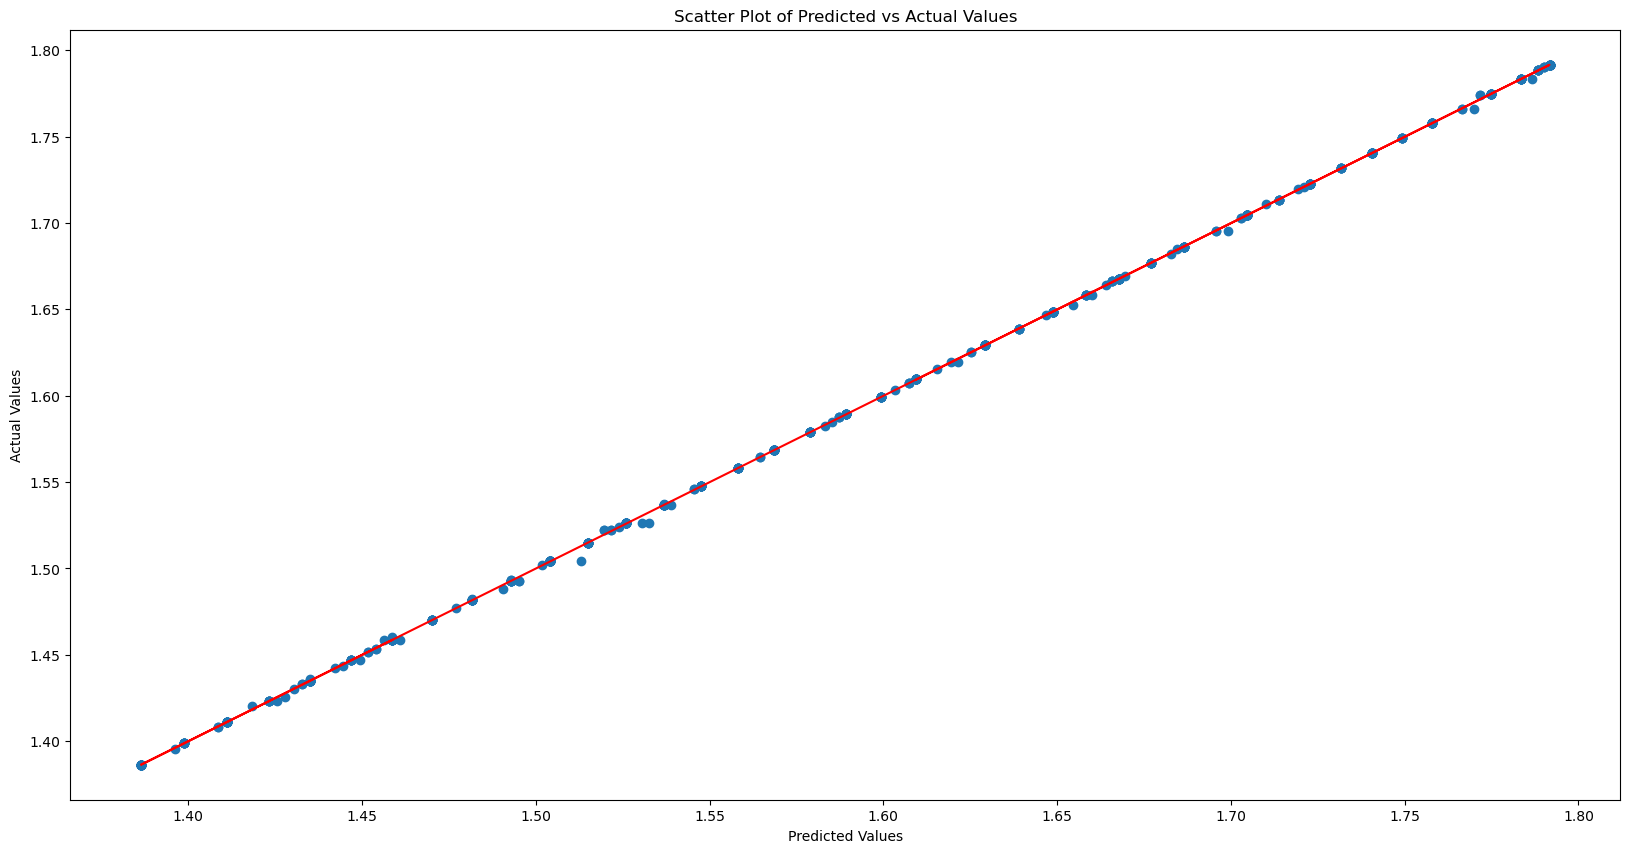

In [177]:
regression_line = np.polyfit(y_test_ha, xgb_predictions_ha, 1)
plt.scatter(y_test_ha, xgb_predictions_ha)
plt.plot(xgb_predictions_ha, np.polyval(regression_line, xgb_predictions_ha), color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.show()

How about xgb?

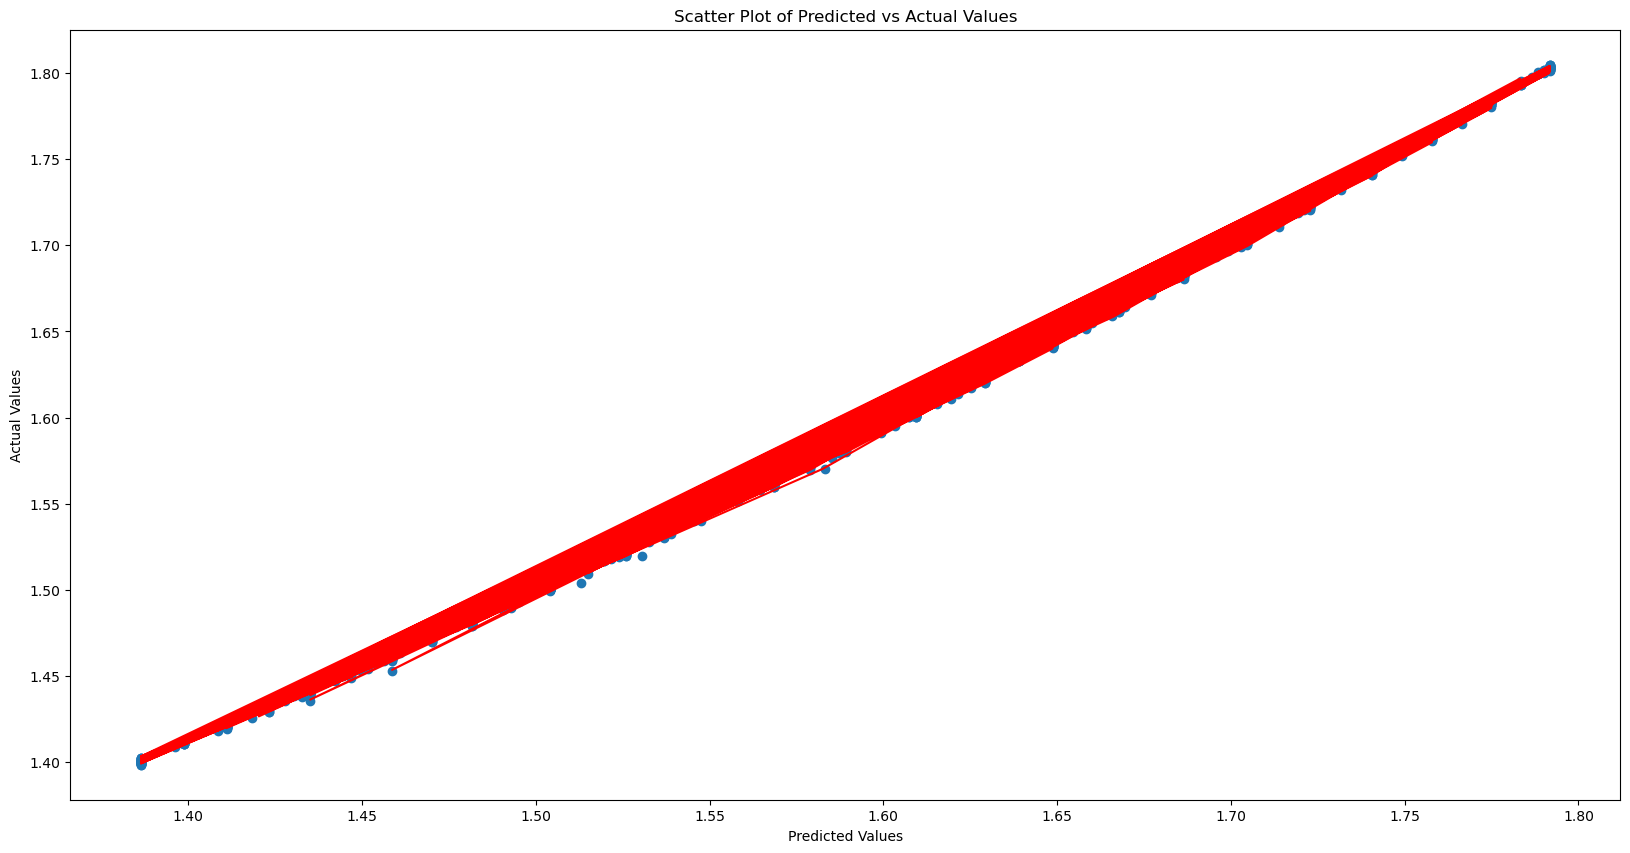

In [179]:
regression_line = np.polyfit(y_test, lr_predictions_ha, 1)
plt.scatter(y_test,lr_predictions_ha)
plt.plot(xgb_predictions_ha, np.polyval(regression_line, lr_predictions_ha), color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.show()


# Highscores: Have we struck gold?
When I heard from Rachel in the morning, I was equally awe-struck and suspicious at the same time. 99.99%? That doesn't sound like something a typical model would achieve. So I spent some time to investigate. (Dat)

The answer: Data Leakage. We've revealed the answer to our model all along.


In [108]:
# Dropping the original 'area' and 'price' columns
data_encoded.drop(['price'], axis=1, inplace=True)

# Displaying the first few rows of the transformed dataset
data_encoded_head = data_encoded.head()


In [109]:
X_ha = data_encoded.drop(['log_price'], axis=1)
y_ha = data_encoded['log_price']
X_train_ha, X_test_ha, y_train_ha, y_test_ha = train_test_split(X_ha, y_ha, test_size=0.25, random_state=42)

In [110]:
lr_model_ha = LinearRegression()
lr_model_ha.fit(X_train_ha, y_train_ha)
lr_predictions_ha = lr_model_ha.predict(X_test_ha)

In [111]:
# Evaluating the Linear Regression Model
lr_r2_ha = r2_score(y_test_ha, lr_predictions_ha)
lr_rmse_ha = np.sqrt(mean_squared_error(y_test_ha, lr_predictions_ha))

# Output the performance metrics
lr_performance_ha = {'Linear Regression R2 Score': lr_r2_ha, 'Linear Regression RMSE': lr_rmse_ha}
lr_performance_ha

{'Linear Regression R2 Score': 0.0020715207950420256,
 'Linear Regression RMSE': 0.2496744723617293}

# The Fault in our Data
After many days of agony, we've come to the conclusion that our data was bad in the first place. This section is going to see why that is.

So after fixing it, the bad result comes again :>

In [130]:
# We will reuse the processed data of Dat's attempt.
df5

,district,area,bed,toilet,legal_status,furniture,price
0,Bình Tân,66.0,2,2,Sổ đỏ/Sổ hồng,1,3.00
1,Bình Tân,66.0,2,2,Hợp đồng mua bán,1,3.10
2,Tân Phú,85.4,2,2,Sổ đỏ/Sổ hồng,2,4.35
3,Bình Tân,78.0,2,2,Hợp đồng mua bán,1,3.50
4,Bình Chánh,82.0,2,2,Sổ đỏ/Sổ hồng,1,3.40
...,...,...,...,...,...,...,...
2750,Bình Tân,32.0,2,2,Sổ đỏ/Sổ hồng,1,3.55
2751,Bình Thạnh,66.0,2,2,Sổ đỏ/Sổ hồng,1,3.20
2752,Phú Nhuận,28.0,2,2,Sổ đỏ/Sổ hồng,1,3.65
2753,Bình Thạnh,60.0,3,2,Sổ đỏ/Sổ hồng,1,4.80


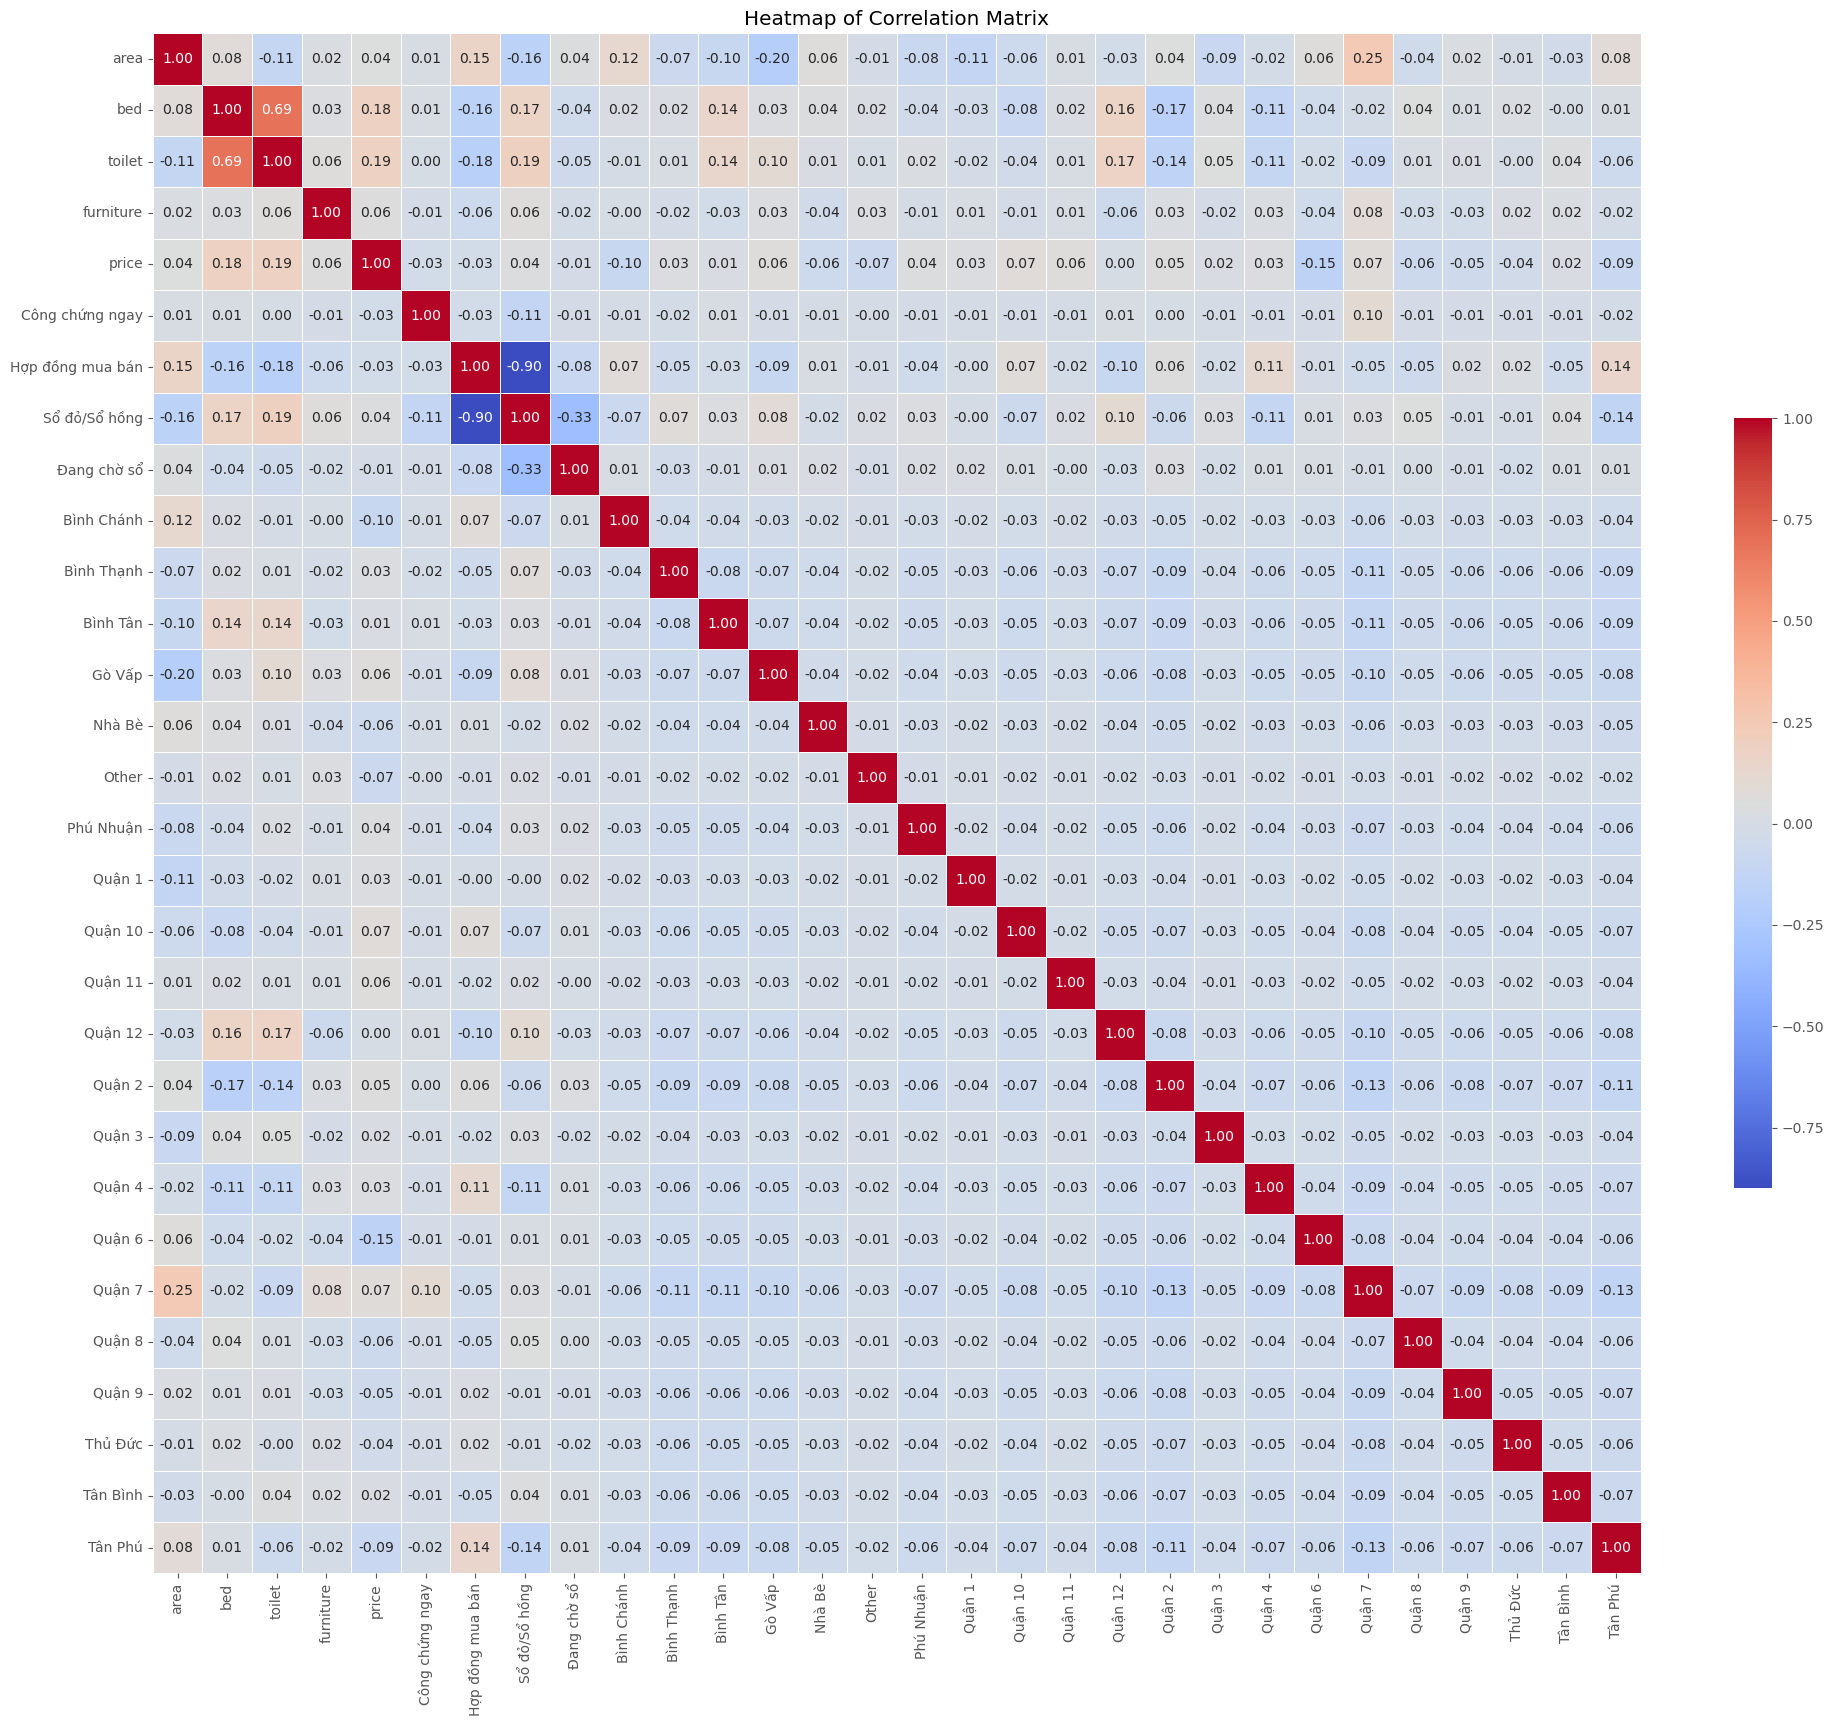

In [131]:
# Calculate the correlation matrix
corr = df7.corr()

# Set up the matplotlib figure
plt.figure(figsize=(24, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Heatmap of Correlation Matrix')

# Show plot
plt.show()

As we can see, there is very little correlation between the information in our data. This could be because of our methodology and principle that we have decided on before collecting the data. We had decided to collect data only on properties with price ranging from 3-5 billion VND, and that narrow band might have led to us not collecting enough variation for other attributes to see any pattern. 

With that we have declared our failure, and because there's no time to crawl and process more data, we have decided to try again, this time with a publicly available dataset for HCMC apartments. This set was collected in June 2021, and the link to the dataset can be found here:

https://github.com/QuangTranUTE/Housing-Price-Prediction/blob/master/datasets/GiaChungCu_HCM_June2021_laydulieu_com.csvZ

# The revenge
## Exploring the data

In [192]:
#Importing the dataset
condos = pd.read_csv(r"C:\Users\tranh\Downloads\GiaChungCu_HCM_June2021_laydulieu_com.csv")

In [193]:
condos

,GIỐNG - LOẠI,GIỐNG - NHU CẦU,GIỐNG - TỈNH THÀNH,QUẬN HUYỆN,GIÁ - TRIỆU ĐỒNG,DIỆN TÍCH - M2,HƯỚNG,SỐ TẦNG,SỐ PHÒNG,SỐ TOILETS,GIẤY TỜ PHÁP LÝ
0,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận 9,2650.0,69.0,NaN,NaN,2.0,2.0,Đã có sổ
1,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận Tân Bình,3970.0,74.1,NaN,NaN,2.0,2.0,Đang chờ sổ
2,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận 9,678.0,46.5,Tây,NaN,1.0,1.0,Đang chờ sổ
3,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận Tân Phú,2870.0,65.0,NaN,NaN,2.0,2.0,NaN
4,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận 9,3000.0,70.0,Đông Bắc,NaN,2.0,2.0,Đã có sổ
...,...,...,...,...,...,...,...,...,...,...,...
1945,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận 7,1500.0,73.0,NaN,NaN,2.0,2.0,Đã có sổ
1946,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận 7,1550.0,73.0,NaN,NaN,2.0,2.0,Đang chờ sổ
1947,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận Tân Phú,2900.0,65.2,NaN,NaN,2.0,2.0,Đang chờ sổ
1948,"Căn hộ, chung cư",Cần bán,Hồ Chí Minh,Quận 7,1720.0,85.0,NaN,NaN,2.0,3.0,Đang chờ sổ


In [199]:
# dropping all of the irrelevant attributes, and those with too many NaN values.
condo1 = condos.drop(["GIỐNG - LOẠI", "GIỐNG - NHU CẦU", "GIỐNG - TỈNH THÀNH", "SỐ TẦNG", "HƯỚNG", "GIẤY TỜ PHÁP LÝ"], axis = 'columns')
condo1.columns = ["district", "price", "area", "room", "toilet"]
#room in this dataset is not very well-defined, so we assume it's going to be bedrooms.

condo1 # .groupby('district')['district'].agg('count')

,district,price,area,room,toilet
0,Quận 9,2650.0,69.0,2.0,2.0
1,Quận Tân Bình,3970.0,74.1,2.0,2.0
2,Quận 9,678.0,46.5,1.0,1.0
3,Quận Tân Phú,2870.0,65.0,2.0,2.0
4,Quận 9,3000.0,70.0,2.0,2.0
...,...,...,...,...,...
1945,Quận 7,1500.0,73.0,2.0,2.0
1946,Quận 7,1550.0,73.0,2.0,2.0
1947,Quận Tân Phú,2900.0,65.2,2.0,2.0
1948,Quận 7,1720.0,85.0,2.0,3.0


Hoc Mon has only 3 data points, so we'll change it's location to Quận 12. This should not change the significance of either, since Quan 12 and Hoc Mon is very similar in demographic, location and development level. Other districts have enough data points, so no need for change.

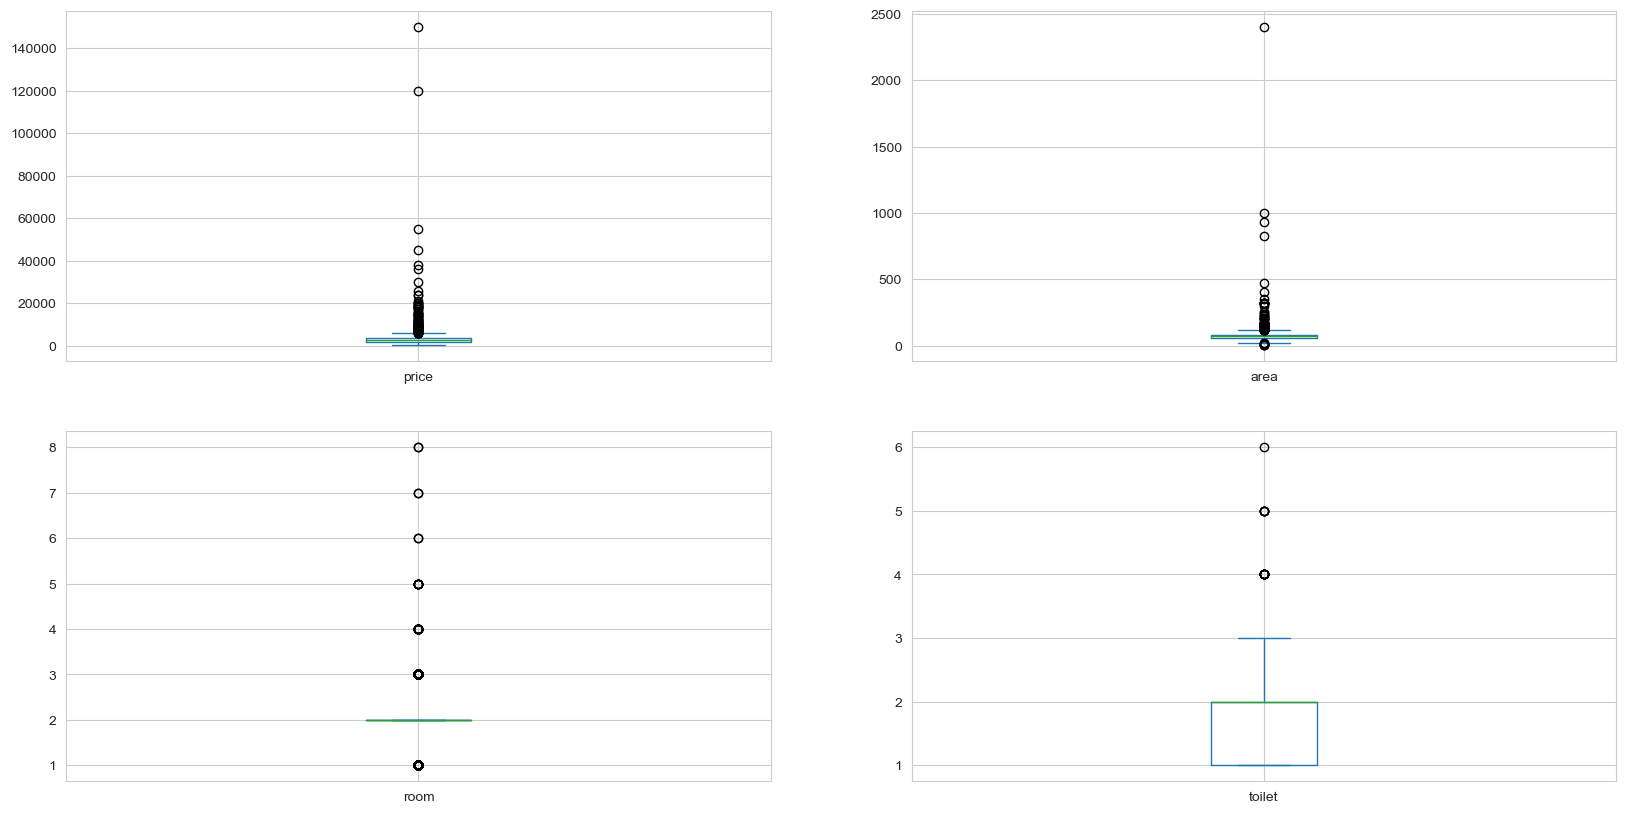

In [200]:
condo1.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

# Find and eliminate outliers

In [202]:
condo1.describe()

,price,area,room,toilet
count,1950.000000,1948.000000,1945.000000,1895.000000
mean,3261.196558,75.409320,2.040617,1.744591
std,5280.514953,70.614754,0.707758,0.585094
min,100.000000,1.000000,1.000000,1.000000
25%,1790.000000,56.000000,2.000000,1.000000
50%,2400.000000,68.000000,2.000000,2.000000
75%,3450.000000,80.000000,2.000000,2.000000
max,150000.000000,2400.000000,8.000000,6.000000


In [ ]:
#Lower Fence - Upper Fence price: -700 - 5940
#Lower Fence - Upper Fence area: 20 - 116
#Lower Fence - Upper Fence room: 2 - 2 (this we will ignore)
#Lower Fence - Upper Fence toilet: -1 - 4 

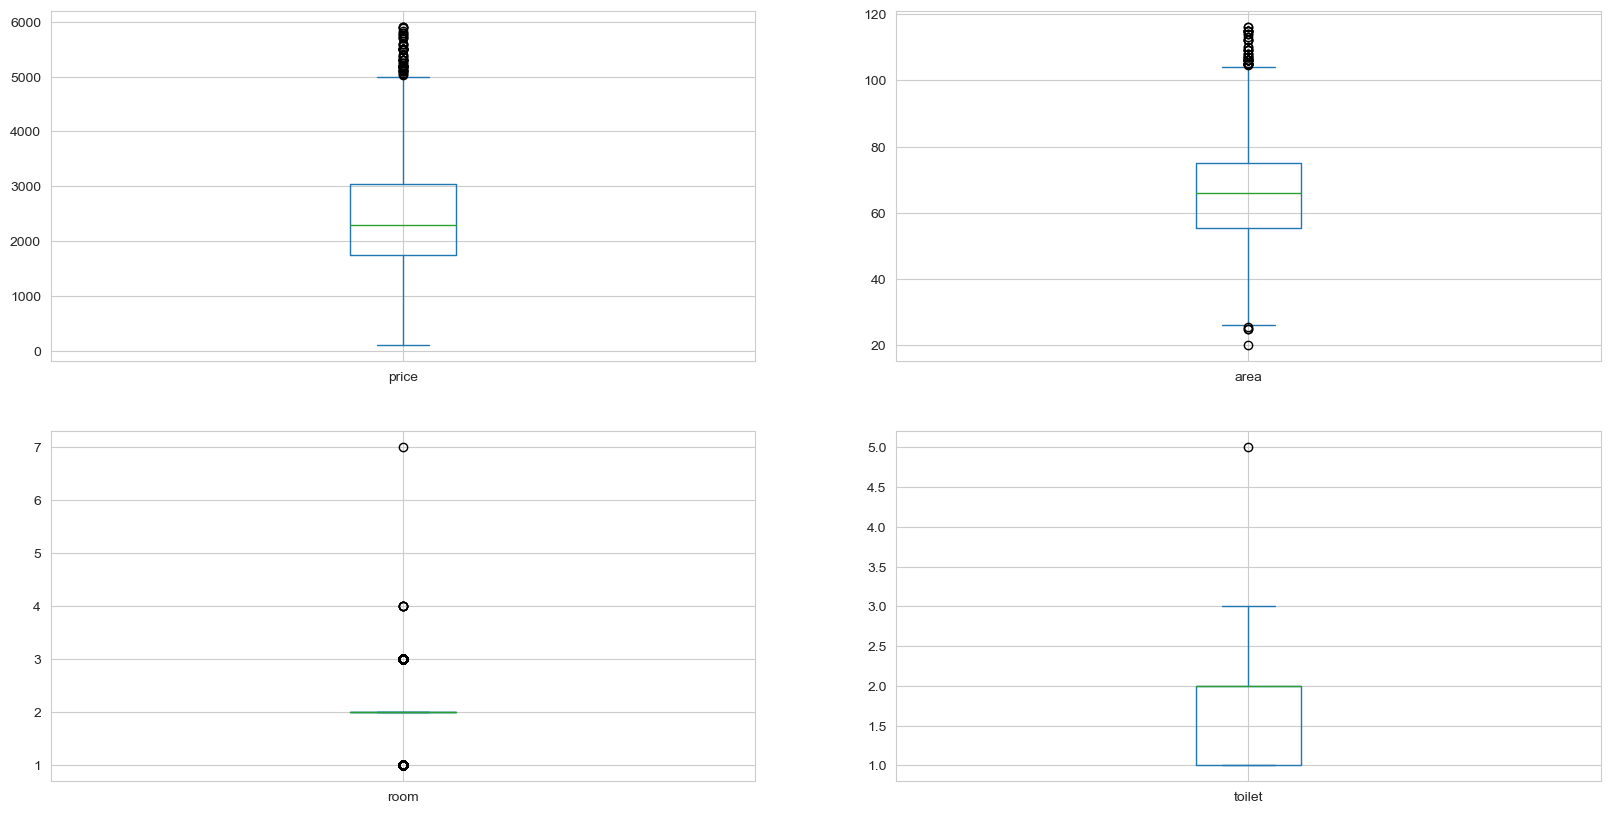

In [211]:
condo2 = condo1[(condo1["area"] >= 20) & (condo1["area"] <= 116) & (condo1["price"] <= 5940)  & (condo1["toilet"] <= 5)]
condo2.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

condo2 should be ready for model building.

In [216]:
condos_dummies_district = pd.get_dummies(condo2["district"])
condo3 = condo2.drop("district", axis = 'columns')
condo4 = pd.concat([condo3, condos_dummies_district], axis =  "columns")
condo4

,price,area,room,toilet,Huyện Bình Chánh,Huyện Hóc Môn,Huyện Nhà Bè,Quận 1,Quận 10,Quận 11,...,Quận 7,Quận 8,Quận 9,Quận Bình Thạnh,Quận Bình Tân,Quận Gò Vấp,Quận Phú Nhuận,Quận Thủ Đức,Quận Tân Bình,Quận Tân Phú
0,2650.0,69.0,2.0,2.0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,3970.0,74.1,2.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,678.0,46.5,1.0,1.0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,2870.0,65.0,2.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,3000.0,70.0,2.0,2.0,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,1500.0,73.0,2.0,2.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1946,1550.0,73.0,2.0,2.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1947,2900.0,65.2,2.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1948,1720.0,85.0,2.0,3.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [217]:
condo4.keys()

Index(['price', 'area', 'room', 'toilet', 'Huyện Bình Chánh', 'Huyện Hóc Môn',
       'Huyện Nhà Bè', 'Quận 1', 'Quận 10', 'Quận 11', 'Quận 12', 'Quận 2',
       'Quận 3', 'Quận 4', 'Quận 5', 'Quận 6', 'Quận 7', 'Quận 8', 'Quận 9',
       'Quận Bình Thạnh', 'Quận Bình Tân', 'Quận Gò Vấp', 'Quận Phú Nhuận',
       'Quận Thủ Đức', 'Quận Tân Bình', 'Quận Tân Phú'],
      dtype='object')

Apparently there's still NaN data in some rows, belonging to columns of toilet and room. This should drop all of them.

In [218]:
condo5 = condo4.dropna(axis = 'rows')

# Building the model
## Splitting the data

In [227]:
condo_X = condo5.drop("price", axis = "columns")
condo_y = condo5["price"]

In [230]:
condo_X_train, condo_X_test, condo_y_train, condo_y_test = train_test_split(condo_X, condo_y, test_size = 0.2, random_state = 1210)

## Training models
We will use the same training models as before.

Linear Regression

In [234]:
from sklearn.linear_model import LinearRegression
condo_lr_clf = LinearRegression()
condo_lr_clf.fit(condo_X_train, condo_y_train)
condo_predictions =  condo_lr_clf.predict(condo_X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error 
# model evaluation 
print( 
  'mean_squared_error : ', mean_squared_error(condo_y_test, condo_predictions)) 
print( 
  'mean_absolute_error : ', mean_absolute_error(condo_y_test, condo_predictions)) 
print(condo_lr_clf.score(condo_X_test, condo_y_test))

mean_squared_error :  558932.9966309275
mean_absolute_error :  551.8438402715549
0.5306211988010687


This is much higher than what we got with our own data. If you see below, the highest score is even 0.70.

In [262]:
cross_val_score(condo_lr_clf, condo_X, condo_y, cv=50)

array([0.6438185 , 0.24511897, 0.53001142, 0.70820021, 0.62486621,
       0.39543231, 0.62707623, 0.32737106, 0.48397463, 0.26718633,
       0.49120102, 0.53009923, 0.48555112, 0.46438495, 0.64667001,
       0.36227827, 0.52444395, 0.54073921, 0.21432381, 0.59986103,
       0.50776505, 0.3820485 , 0.57174028, 0.54712491, 0.39894269,
       0.52971205, 0.69494255, 0.47383249, 0.53601891, 0.29901958,
       0.60966893, 0.54203802, 0.52201169, 0.55027225, 0.62576742,
       0.47966828, 0.33571471, 0.50204107, 0.45183772, 0.55325475,
       0.40378441, 0.27477827, 0.5212561 , 0.29897242, 0.43681592,
       0.37490331, 0.48230204, 0.59181592, 0.4610686 , 0.33205522])

Lasso Regression

In [236]:
condo_model = Lasso(alpha = 1.0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
condo_model.fit(condo_X_train, condo_y_train)
condo_model.score(condo_X_test, condo_y_test)

0.5272516338935058

In [237]:
cross_val_score(condo_model, condo_X, condo_y, cv=10)

array([0.58281586, 0.49163216, 0.53276542, 0.45879849, 0.48762804,
       0.54517972, 0.57318738, 0.48268274, 0.40140869, 0.48404856])

SVM

In [238]:
condo_svm_clf = svm.SVR()
condo_svm_clf.fit(condo_X_train, condo_y_train)
condo_svm_clf.score(condo_X_test, condo_y_test)

0.041670738085681114

In [239]:
cross_val_score(condo_svm_clf, condo_X, condo_y, cv=10)

array([ 0.00897771, -0.02483391,  0.00908053,  0.02148622,  0.0546903 ,
        0.00045864,  0.06523915,  0.04740759,  0.0717728 ,  0.03520042])

This model did not work well

Gradient Boosting Regressor

In [263]:
condo_gboost_clf = GradientBoostingRegressor(random_state = 1)
condo_gboost_clf.fit(condo_X_train, condo_y_train)
condo_gboost_clf.score(condo_X_test, condo_y_test)

0.5535767990312317

In [264]:
cross_val_score(condo_gboost_clf, condo_X, condo_y, cv=10)

array([0.61104856, 0.52264214, 0.48958989, 0.46344814, 0.50757718,
       0.59350022, 0.58714979, 0.53483541, 0.40243322, 0.55078316])

Random Forest Regressor

In [265]:
condo_rf_clf = RandomForestRegressor(random_state = 6)
condo_rf_clf.fit(condo_X_train, condo_y_train)
condo_rf_clf.score(condo_X_test, condo_y_test)

0.547603024683421

In [266]:
cross_val_score(condo_rf_clf, condo_X, condo_y, cv=10)

array([0.61907332, 0.42148282, 0.52794947, 0.44131123, 0.5277023 ,
       0.57203806, 0.54854115, 0.48495897, 0.31925609, 0.58712732])

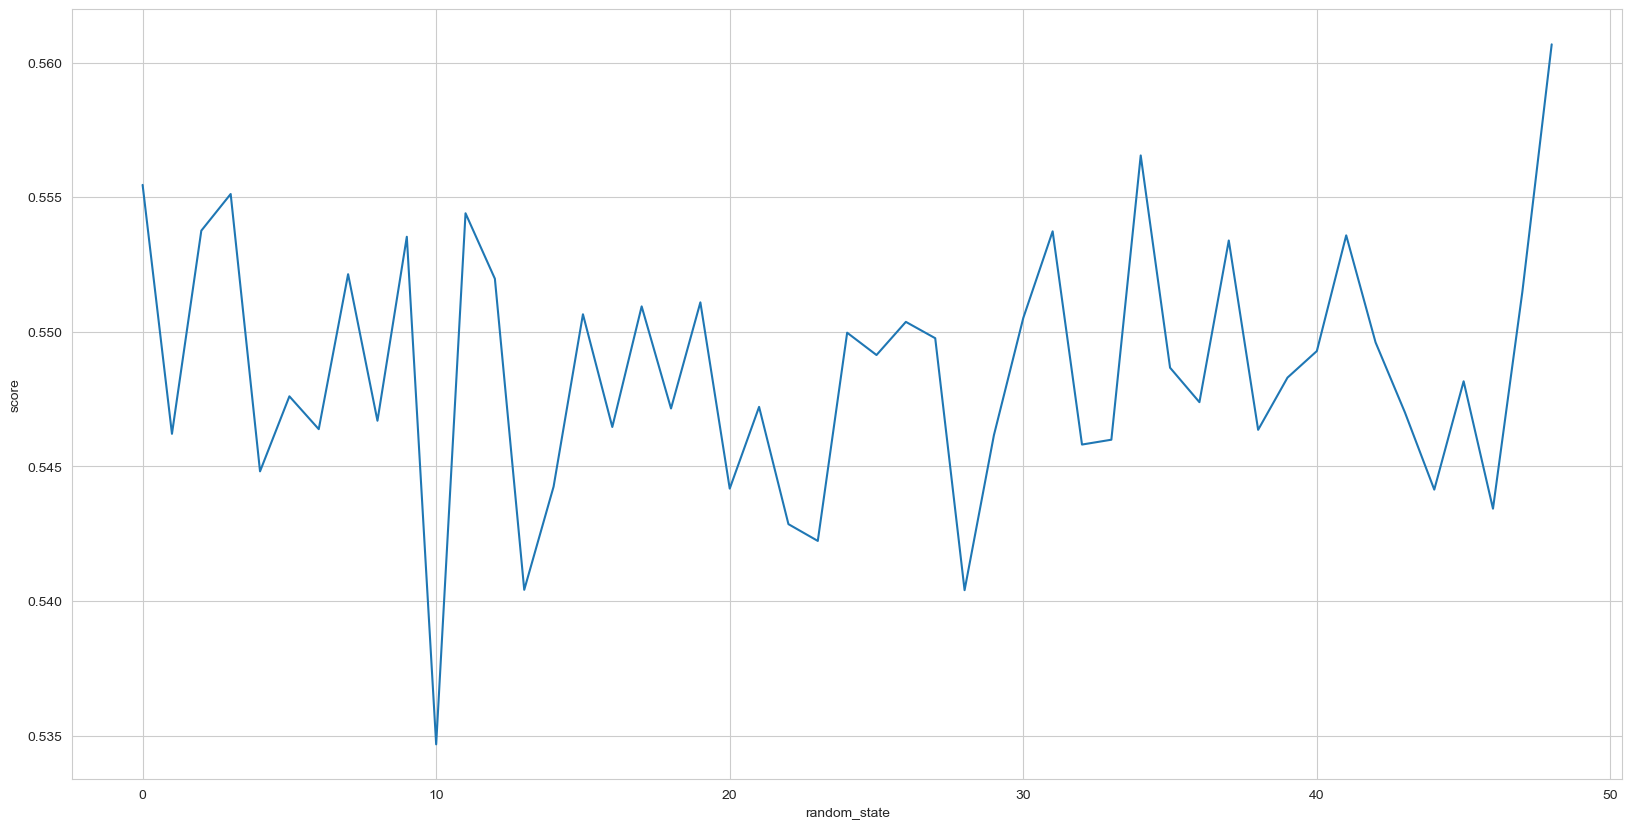

In [252]:
# We don't know which random_state works best. Maybe we can find out this way?
condo_rf_score_list = []
for i in range(1, 50):
    condo_rf_clf = RandomForestRegressor(random_state = i)
    condo_rf_clf.fit(condo_X_train, condo_y_train)
    condo_rf_score_list.append(condo_rf_clf.score(condo_X_test, condo_y_test))

plt.plot(condo_rf_score_list)
plt.xlabel('random_state')
plt.ylabel('score')

plt.show()

Decision Tree Regressor

In [243]:
# Again we plot the max_depth from 1 to 50 to find the best score

condo_score_list = []
for i in range(1, 50):
    condo_dt_clf = DecisionTreeRegressor(max_depth = i)
    condo_dt_clf.fit(condo_X_train, condo_y_train)
    condo_score_list.append(condo_dt_clf.score(condo_X_test, condo_y_test))

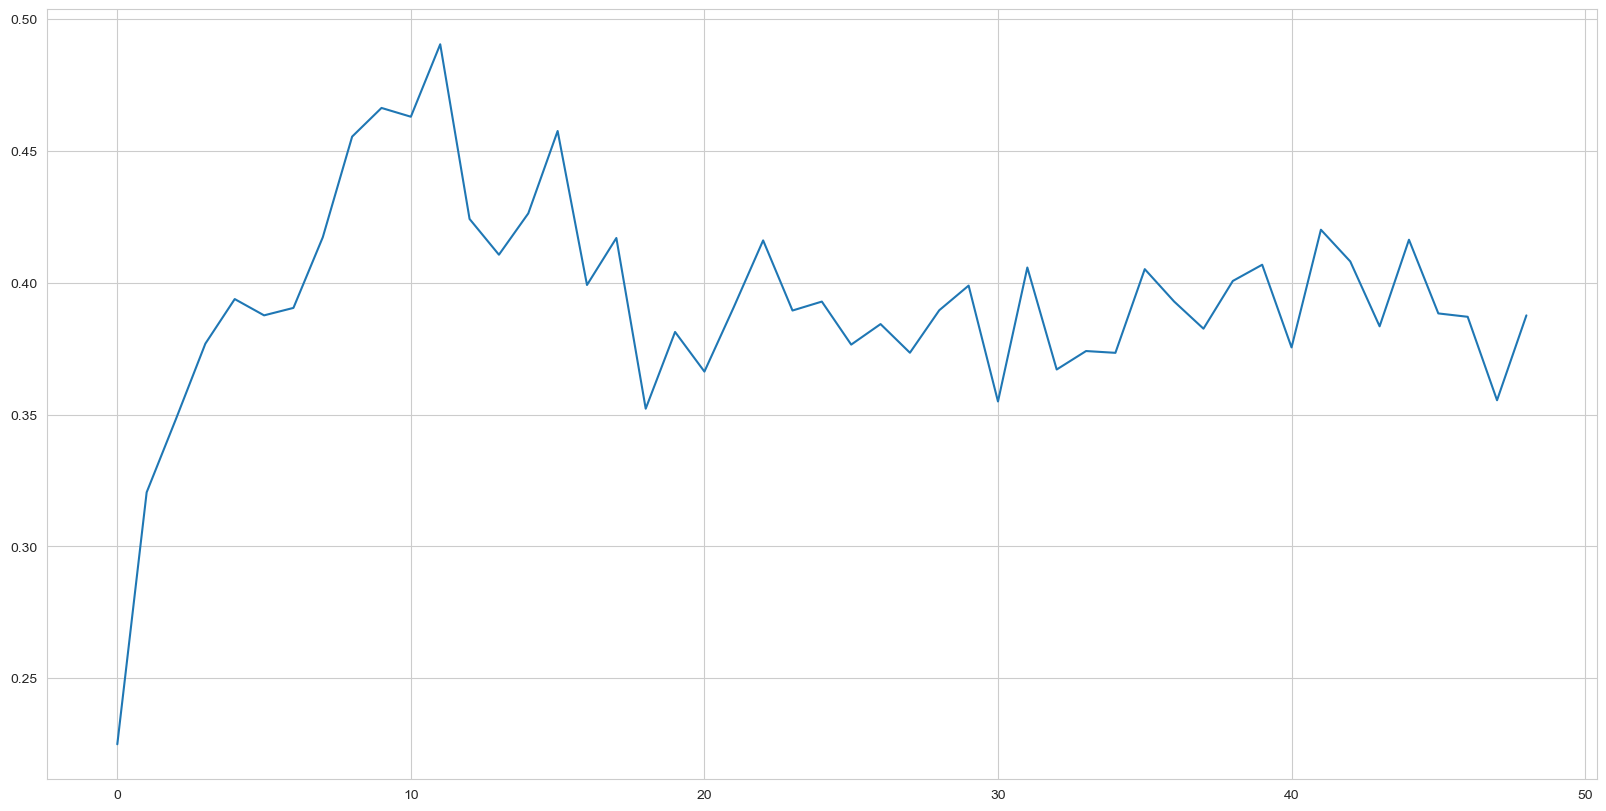

In [245]:
plt.plot(condo_score_list)
plt.show()

Gaussian Process Regressor

In [257]:
condo_gnr_clf = GaussianProcessRegressor()
condo_gnr_clf.fit(condo_X_train, condo_y_train)
condo_gnr_clf.score(condo_X_test, condo_y_test)

-1365.526810756179

In [258]:
cross_val_score(condo_gnr_clf, condo_X, condo_y, cv=10)

array([-8.33041382e+04, -7.67096532e+03, -2.41547605e+03, -6.05579391e+01,
       -1.74887026e+03, -2.10094715e+03, -2.74363542e+03, -6.99717509e+02,
       -4.30712339e+03, -1.60594226e+03])

I wonder how it got this bad a score.

Ada Boost Regressor

In [259]:
condo_abc_clf = AdaBoostRegressor(n_estimators=100)
condo_abc_clf.fit(condo_X_train, condo_y_train)
condo_abc_clf.score(condo_X_test, condo_y_test)

0.36639283192042904

In [267]:
cross_val_score(condo_abc_clf, condo_X, condo_y, cv=10)

array([0.4080531 , 0.31484024, 0.30789993, 0.34327339, 0.28953115,
       0.40102911, 0.40526802, 0.32752189, 0.18215447, 0.27137024])

Scores for this model range from 40-50%, which is much higher than what we have achieved for our own dataset.

# Conclusion

Check data and if it has some problems, change the data as soon as possible. Also, if the accuracy of the model is too high, maybe there are some issues like overfitting. Always have expectations on how the model should behave.

# Work division

**Data crawling/collection:** Rachel

**Preliminary Data Processing:** Rachel

**Data Exploration/Further Processing:** Dat, Rachel

**Building Models:** Dat, Rachel

**Annotating code:** Dat

**Building the presentation:** Dat, Rachel